Assigment2_codigo

imports:

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


carregar as informações

In [27]:
data = pd.read_csv("hcc_dataset.csv")


pré-processamento de dados

In [28]:
# Use raw strings to avoid unicode escape issues in file paths
input_file_path = 'hcc_dataset.csv'
output_file_path = 'hcc_dataset_modified.csv'

# Open the original CSV file for reading
with open(input_file_path, 'r') as infile:
    reader = csv.reader(infile)
    rows = list(reader)

# Open a new CSV file for writing
with open(output_file_path, 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    # Process each row from the original file
    for row in rows:
        new_row = []
        for value in row:
            if value == '?':
                new_row.append('Nan')
            elif value == 'Yes':
                new_row.append('1')
            elif value == 'No':
                new_row.append('0')
            else:
                new_row.append(value)
        writer.writerow(new_row)

# Load the modified CSV file into a pandas DataFrame
data = pd.read_csv(output_file_path)

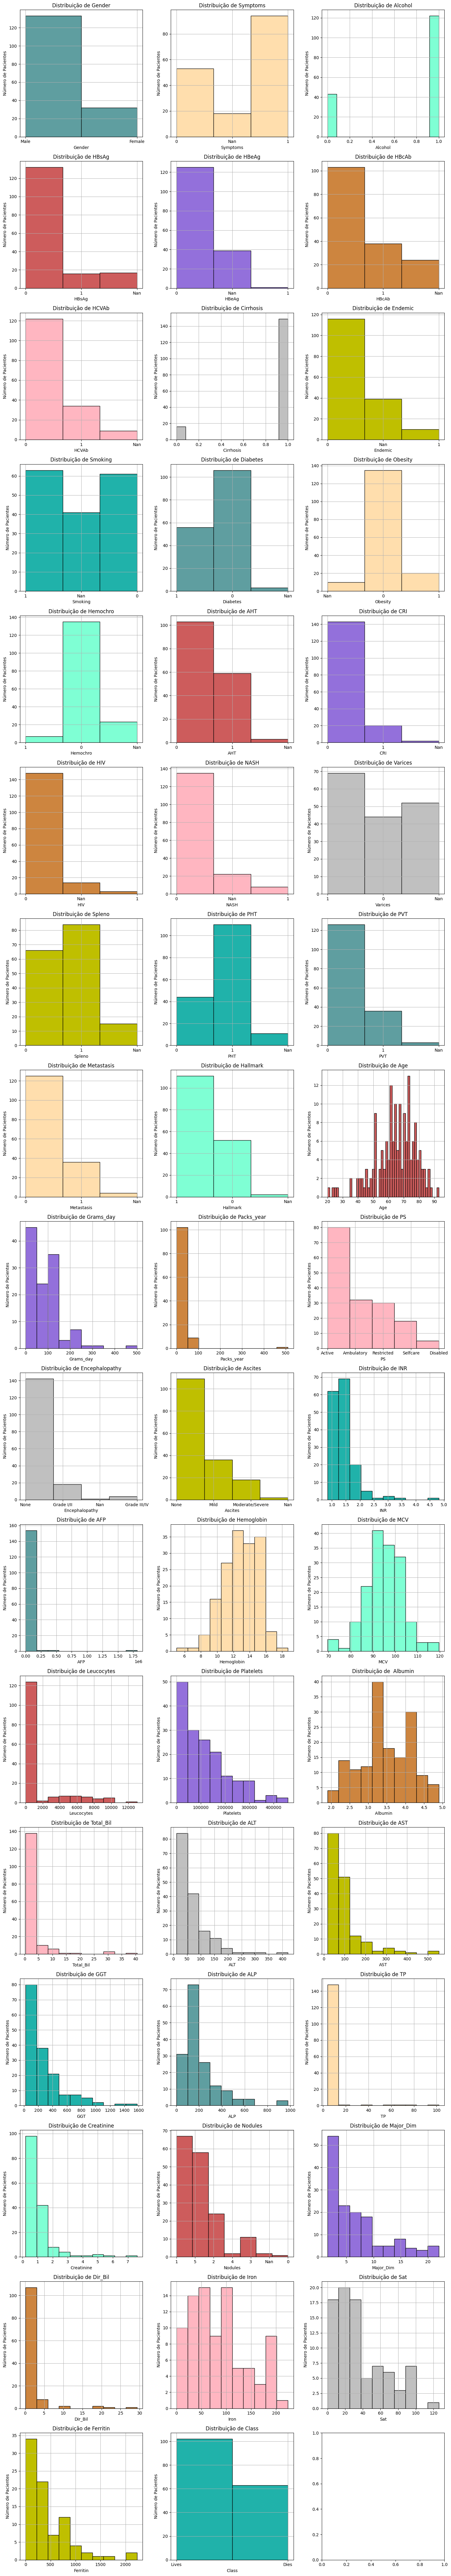

In [29]:
def plot_histograms(data):
    # Definir o número máximo de colunas a serem plotadas de uma vez
    max_columns_per_plot = 3
 
    # Definir o esquema de cores
    color_scheme = ['cadetblue', 'navajowhite', 'aquamarine', 'indianred', 'mediumpurple', 'peru', 'lightpink', 'silver', 'y', 'lightseagreen']

    num_plots = len(data.columns)
    num_rows = math.ceil(num_plots / max_columns_per_plot)

    fig, axes = plt.subplots(num_rows, max_columns_per_plot, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        subset_data = data[column]
        ax = axes[i]

        if pd.api.types.is_numeric_dtype(subset_data):
            cleaned_data = subset_data.fillna('None')
            num_bins = int(len(cleaned_data) ** 0.5)
            num_bins = max(10, num_bins)

            if cleaned_data.nunique() > 20:
                num_bins = min(50, cleaned_data.nunique())

            ax.hist(cleaned_data, bins=num_bins, color=color_scheme[i % len(color_scheme)], edgecolor='black')

            # Adicionar barra para 'NaN' e 'None'
            nan_count = subset_data.isna().sum()
            if nan_count > 0:
                ax.bar('NaN', nan_count, color='gray', alpha=0.5)
            
            none_count = (subset_data == 'None').sum()
            if none_count > 0:
                ax.bar('None', none_count, color='gray', alpha=0.5)

        else:
            cleaned_data = subset_data.fillna('None')

            if cleaned_data.nunique() > 15:
                cleaned_data = pd.to_numeric(cleaned_data, errors='coerce')
                cleaned_data = cleaned_data.dropna()
                interval_size = (cleaned_data.max() - cleaned_data.min()) / 10
                bins = [cleaned_data.min() + i * interval_size for i in range(11)]
            else:
                bins = cleaned_data.nunique()

            ax.hist(cleaned_data, bins=bins, color=color_scheme[i % len(color_scheme)], edgecolor='black')

            # Adicionar barra para 'None'
            none_count = (subset_data == 'None').sum()
            if none_count > 0:
                ax.bar('None', none_count, color='gray', alpha=0.5)

        ax.set_title(f'Distribuição de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Número de Pacientes')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Carregar os dados do arquivo CSV para um DataFrame
data = pd.read_csv("hcc_dataset_modified.csv")

# Criar os gráficos para cada variável
plot_histograms(data)

Matriz de correlação

/var/folders/pv/vxb7mlk168v147v0ds64v4pw0000gq/T/ipykernel_3922/1480751112.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[class_column] = data[class_column].replace({'Lives': 1, 'Dies': 0})


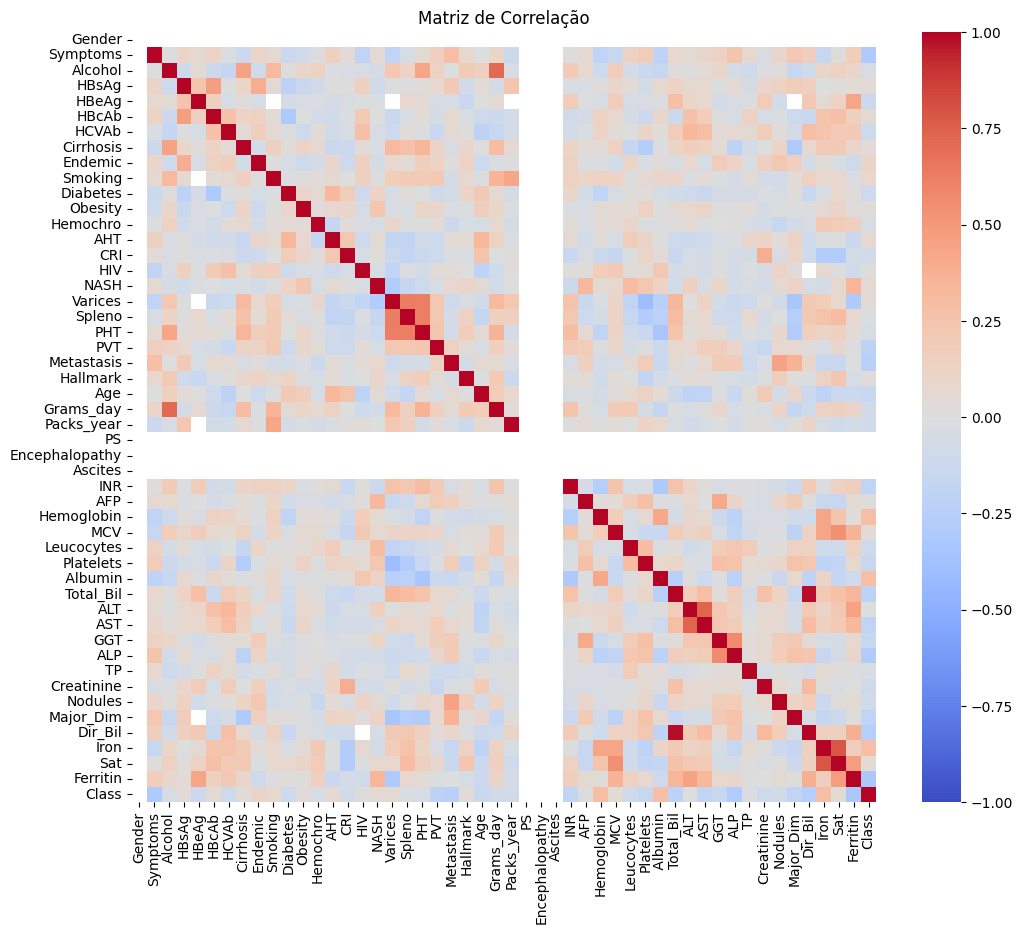

In [30]:
# Verificar o nome exato da última coluna
class_column = data.columns[-1]

# Converter 'lives' para 1 e 'dies' para 0 na coluna 'class'
data[class_column] = data[class_column].replace({'Lives': 1, 'Dies': 0})

# Identificar colunas que podem ser convertidas para numéricas, incluindo aquelas com NaN
numeric_data = data.apply(pd.to_numeric, errors='coerce')

# Calcular a matriz de correlação
correlation_matrix = numeric_data.corr()

# Plotar o heatmap da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlação")
plt.show()


Matriz de Correlação Numérica

In [31]:
# Verificar o nome exato da última coluna
class_column = data.columns[-1]

# Converter 'lives' para 1 e 'dies' para 0 na coluna 'class'
data[class_column] = data[class_column].replace({'Lives': 1, 'Dies': 0})

# Identificar colunas que podem ser convertidas para numéricas, incluindo aquelas com NaN
numeric_data = data.apply(pd.to_numeric, errors='coerce')

# Mostrar a matriz de correlação
print("Matriz de Correlação:")
print(correlation_matrix)


Matriz de Correlação:
                Gender  Symptoms   Alcohol     HBsAg     HBeAg     HBcAb  \
Gender             NaN       NaN       NaN       NaN       NaN       NaN   
Symptoms           NaN  1.000000 -0.011104  0.116589  0.070173  0.132498   
Alcohol            NaN -0.011104  1.000000 -0.106917  0.052186 -0.117272   
HBsAg              NaN  0.116589 -0.106917  1.000000  0.252982  0.469429   
HBeAg              NaN  0.070173  0.052186  0.252982  1.000000  0.149515   
HBcAb              NaN  0.132498 -0.117272  0.469429  0.149515  1.000000   
HCVAb              NaN -0.024346 -0.161359 -0.015611 -0.047137  0.271603   
Cirrhosis          NaN -0.125950  0.458652  0.103418  0.027663  0.127972   
Endemic            NaN  0.103577 -0.098503  0.397119 -0.035377  0.137623   
Smoking            NaN  0.063274  0.314748  0.054699       NaN  0.035719   
Diabetes           NaN -0.131382  0.015357 -0.213314 -0.066376 -0.304634   
Obesity            NaN -0.100917  0.104758 -0.140257 -0.036616 -0.

colunas mais relevantes

In [32]:
# Calcular a quantidade de vezes que a palavra "Nan" aparece em cada coluna
nan_counts = (data.astype(str) == "Nan").sum()

# Selecionar as colunas com menos ocorrências da palavra "Nan" (menos de 10% dos dados)
relevant_columns_nan = nan_counts[nan_counts < 0.1 * len(data)]

# Selecionar apenas colunas numéricas
numeric_columns = data.select_dtypes(include=[float, int])

# Calcular a variância de cada coluna numérica
variance = numeric_columns.var()

# Selecionar as colunas com maior variância
relevant_columns_variance = variance.nlargest(len(numeric_columns.columns))

# Mostrar as colunas mais relevantes com base na quantidade de vezes que a palavra "Nan" aparece e na variância
print("Colunas mais relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:")
print(relevant_columns_nan)
print("\nColunas mais relevantes com base na variância:")
print(relevant_columns_variance)

# Agora, vamos encontrar as colunas menos relevantes com base na quantidade de vezes que a palavra "Nan" aparece e na variância
print("\nColunas menos relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:")
least_relevant_columns_nan = nan_counts[nan_counts >= 0.1 * len(data)]
print(least_relevant_columns_nan)

print("\nColunas menos relevantes com base na variância:")
least_relevant_columns_variance = variance.nsmallest(len(numeric_columns.columns))
print(least_relevant_columns_variance)



Colunas mais relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:
Gender             0
Alcohol            0
HCVAb              9
Cirrhosis          0
Diabetes           3
Obesity           10
AHT                3
CRI                2
HIV               14
Spleno            15
PHT               11
PVT                3
Metastasis         4
Hallmark           2
Age                0
PS                 0
Encephalopathy     1
Ascites            2
INR                4
AFP                8
Hemoglobin         3
MCV                3
Leucocytes         3
Platelets          3
 Albumin           6
Total_Bil          5
ALT                4
AST                3
GGT                3
ALP                3
TP                11
Creatinine         7
Nodules            2
Class              0
dtype: int64

Colunas mais relevantes com base na variância:
Age          177.409978
Class          0.237472
Alcohol        0.193865
Cirrhosis      0.088101
dtype: float64

Colunas menos relevantes com

In [33]:
percentagem_nan = {}

# Obter o número total de linhas no DataFrame
total_linhas = len(data)

# Percorrer as colunas do DataFrame
for coluna in data.columns:
    # Contar o número de ocorrências de 'Nan' na coluna atual
    contagem_nan = (data[coluna] == 'Nan').sum()
    
    # Calcular a percentagem de 'Nan' na coluna atual
    percentagem = (contagem_nan / total_linhas) * 100
    
    # Armazenar a percentagem de 'Nan' na coluna atual no dicionário
    percentagem_nan[coluna] = percentagem

# Exibir a percentagem de 'Nan' em cada categoria
for categoria, percentagem in percentagem_nan.items():
    print(f"{categoria}: {percentagem:.2f}%")



Gender: 0.00%
Symptoms: 10.91%
Alcohol: 0.00%
HBsAg: 10.30%
HBeAg: 23.64%
HBcAb: 14.55%
HCVAb: 5.45%
Cirrhosis: 0.00%
Endemic: 23.64%
Smoking: 24.85%
Diabetes: 1.82%
Obesity: 6.06%
Hemochro: 13.94%
AHT: 1.82%
CRI: 1.21%
HIV: 8.48%
NASH: 13.33%
Varices: 31.52%
Spleno: 9.09%
PHT: 6.67%
PVT: 1.82%
Metastasis: 2.42%
Hallmark: 1.21%
Age: 0.00%
Grams_day: 29.09%
Packs_year: 32.12%
PS: 0.00%
Encephalopathy: 0.61%
Ascites: 1.21%
INR: 2.42%
AFP: 4.85%
Hemoglobin: 1.82%
MCV: 1.82%
Leucocytes: 1.82%
Platelets: 1.82%
 Albumin: 3.64%
Total_Bil: 3.03%
ALT: 2.42%
AST: 1.82%
GGT: 1.82%
ALP: 1.82%
TP: 6.67%
Creatinine: 4.24%
Nodules: 1.21%
Major_Dim: 12.12%
Dir_Bil: 26.67%
Iron: 47.88%
Sat: 48.48%
Ferritin: 48.48%
Class: 0.00%


correlação entre pares de colunas

In [34]:
# Calcular a matriz de correlação entre as colunas numéricas
correlation_matrix = numeric_data.corr()

# Transformar a matriz em uma série para facilitar a classificação
correlation_series = correlation_matrix.unstack().sort_values()

# Filtrar os pares de colunas com maior correlação positiva, excluindo os pares onde as colunas são as mesmas
positive_correlation_pairs = correlation_series[(correlation_series > 0.5) & (correlation_series.index.get_level_values(0) != correlation_series.index.get_level_values(1))][-10:]

# Filtrar os pares de colunas com maior correlação negativa, excluindo os pares onde as colunas são as mesmas
negative_correlation_pairs = correlation_series[(correlation_series < 0.5) & (correlation_series.index.get_level_values(0) != correlation_series.index.get_level_values(1))][:10]

# Mostrar os 10 piores pares de colunas com maior correlação negativa
print("\nOs 10 piores pares de colunas com maior correlação negativa:")
print(negative_correlation_pairs)

# Mostrar os 10 melhores pares de colunas com maior correlação positiva
print("\nOs 10 melhores pares de colunas com maior correlação positiva:")
print(positive_correlation_pairs)





Os 10 piores pares de colunas com maior correlação negativa:
Varices    Platelets   -0.401433
Platelets  Varices     -0.401433
PHT         Albumin    -0.342394
 Albumin   PHT         -0.342394
Major_Dim  Varices     -0.337071
Varices    Major_Dim   -0.337071
Ferritin   Class       -0.321489
Class      Ferritin    -0.321489
INR         Albumin    -0.310947
 Albumin   INR         -0.310947
dtype: float64

Os 10 melhores pares de colunas com maior correlação positiva:
Varices    Spleno       0.629077
Spleno     Varices      0.629077
Alcohol    Grams_day    0.712681
Grams_day  Alcohol      0.712681
AST        ALT          0.727780
ALT        AST          0.727780
Sat        Iron         0.782957
Iron       Sat          0.782957
Total_Bil  Dir_Bil      0.978124
Dir_Bil    Total_Bil    0.978124
dtype: float64


Plot_diff()

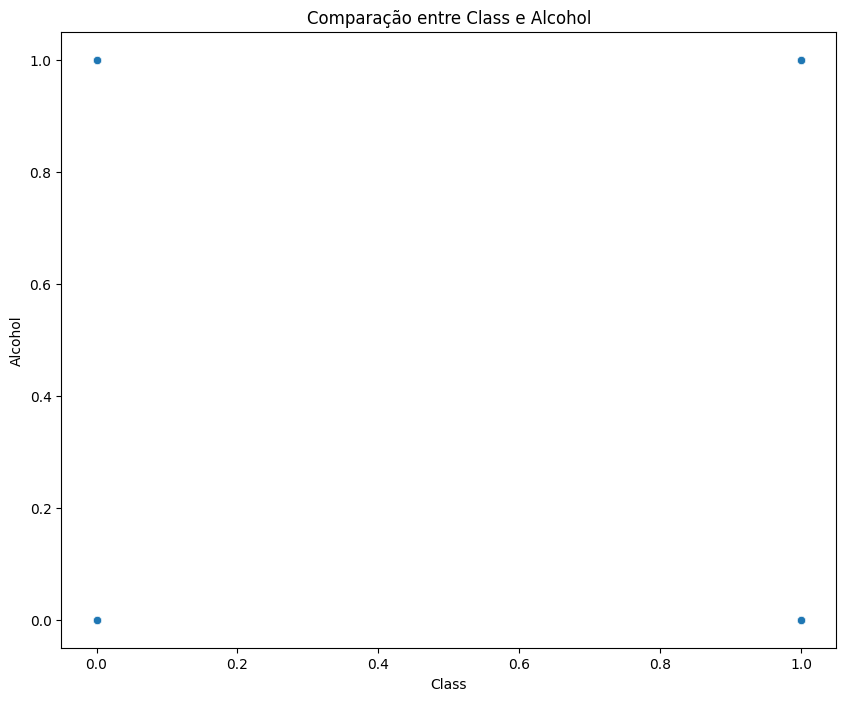

In [35]:
def plot_diffs(data, column1, column2):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=column1, y=column2, data=data)
    plt.title(f"Comparação entre {column1} e {column2}")
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.show()

# Exemplo de uso:
plot_diffs(data, 'Class', 'Alcohol')

faz a correlaçao entre colunas, os pares que tiverem mais correlaçao entre eles, um deles é removido de acordo com a correlação mais baixa com a class

In [36]:
# Função para remover colunas do DataFrame
def remove_columns(data, columns_to_drop):
    columns = [col[0] for col in columns_to_drop]
    return data.drop(columns=columns)

# Carregar os dados do arquivo CSV para um DataFrame
data = pd.read_csv("hcc_dataset_modified.csv")

# Verificar o nome exato da última coluna
class_column = data.columns[-1]

# Converter 'Lives' para 1 e 'Dies' para 0 na coluna 'class'
data[class_column] = data[class_column].replace({'Lives': 1, 'Dies': 0})

# Identificar colunas que podem ser convertidas para numéricas, incluindo aquelas com NaN
numeric_data = data.apply(pd.to_numeric, errors='coerce')

# Calculando as correlações entre as colunas
correlation_matrix = numeric_data.corr()

# Encontrar todos os pares de colunas com correlação superior a 0.6 entre si (exceto a última coluna)
highly_correlated_pairs = []
for i, col1 in enumerate(correlation_matrix.columns[:-1]):
    for col2 in correlation_matrix.columns[i + 1:-1]:
        corr = correlation_matrix.loc[col1, col2]
        if abs(corr) > 0.6:
            highly_correlated_pairs.append((col1, col2, corr))

# Calcular a correlação entre cada coluna e a última coluna
correlation_with_class = correlation_matrix.iloc[:-1, -1]

# Escolher a coluna mais correlacionada com a última coluna para cada par de colunas
columns_to_keep = []
columns_to_drop = []
for pair in highly_correlated_pairs:
    col1, col2, corr_pair = pair
    corr_col1 = correlation_with_class[col1]
    corr_col2 = correlation_with_class[col2]
    # Comparar as correlações considerando a direção dos números negativos
    if corr_col1 >= 0 and corr_col2 >= 0:
        column_to_keep = col1 if corr_col1 > corr_col2 else col2
        column_to_drop = col2 if corr_col1 > corr_col2 else col1
    elif corr_col1 < 0 and corr_col2 < 0:
        column_to_keep = col1 if corr_col1 > corr_col2 else col2
        column_to_drop = col2 if corr_col1 > corr_col2 else col1
    else:
        column_to_keep = col1 if corr_col1 >= corr_col2 else col2
        column_to_drop = col2 if corr_col1 >= corr_col2 else col1
    columns_to_keep.append(column_to_keep)
    columns_to_drop.append((column_to_drop, corr_col1, corr_col2, corr_pair))

# Remover as colunas menos correlacionadas com a última coluna
data = remove_columns(data, columns_to_drop)

# Salvar o DataFrame atualizado em um novo arquivo
# Substitua 'caminho_para_o_novo_arquivo.csv' pelo caminho do novo arquivo
data.to_csv('hcc_dataset_modified_2.csv', index=False, na_rep='None')

# Imprimindo as colunas a serem mantidas
print("Colunas a serem mantidas:")
for col in columns_to_keep:
    print(f"  {col}")

# Imprimindo as colunas a serem eliminadas e suas correlações
print("\nColunas a serem eliminadas e suas correlações:")
for col, corr_col1, corr_col2, corr_pair in columns_to_drop:
    print(f"  {col}:")
    print(f"    - Correlação com a última coluna: {corr_col1}")
    print(f"    - Correlação com a última coluna: {corr_col2}")
    print(f"    - Correlação entre si: {corr_pair}")

print(data.head())


Colunas a serem mantidas:
  Alcohol
  Varices
  Varices
  Spleno
  Total_Bil
  ALT
  Iron

Colunas a serem eliminadas e suas correlações:
  Grams_day:
    - Correlação com a última coluna: -0.04030244125997573
    - Correlação com a última coluna: -0.08657283374460056
    - Correlação entre si: 0.7126814534096568
  Spleno:
    - Correlação com a última coluna: 0.05383931070261069
    - Correlação com a última coluna: -0.029883021110990584
    - Correlação entre si: 0.6290769410869348
  PHT:
    - Correlação com a última coluna: 0.05383931070261069
    - Correlação com a última coluna: -0.0419849468965806
    - Correlação entre si: 0.6243713415848886
  PHT:
    - Correlação com a última coluna: -0.029883021110990584
    - Correlação com a última coluna: -0.0419849468965806
    - Correlação entre si: 0.6177429639164123
  Dir_Bil:
    - Correlação com a última coluna: -0.2239608438802556
    - Correlação com a última coluna: -0.2649031010001527
    - Correlação entre si: 0.978124216733424

/var/folders/pv/vxb7mlk168v147v0ds64v4pw0000gq/T/ipykernel_3922/3548978647.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[class_column] = data[class_column].replace({'Lives': 1, 'Dies': 0})


tira as colunas menos relevantes

In [37]:
# Carregar os dados do arquivo CSV para um DataFrame
data = pd.read_csv("hcc_dataset_modified_2.csv")

# Calcular a quantidade de vezes que a palavra "Nan" aparece em cada coluna
nan_counts = (data.astype(str) == "Nan").sum()

# Selecionar as colunas com menos ocorrências da palavra "Nan" (menos de 10% dos dados)
relevant_columns_nan = nan_counts[nan_counts < 0.1 * len(data)]

# Selecionar apenas colunas numéricas
numeric_columns = data.select_dtypes(include=[float, int])

# Calcular a variância de cada coluna numérica
variance = numeric_columns.var()

# Selecionar as colunas com maior variância
relevant_columns_variance = variance.nlargest(len(numeric_columns.columns))

# Mostrar as colunas mais relevantes com base na quantidade de vezes que a palavra "Nan" aparece e na variância
print("Colunas mais relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:")
print(relevant_columns_nan)
print("\nColunas mais relevantes com base na variância:")
print(relevant_columns_variance)

# Encontrar as colunas menos relevantes com base na quantidade de vezes que a palavra "Nan" aparece e na variância
print("\nColunas menos relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:")
least_relevant_columns_nan = nan_counts[nan_counts >= 0.1 * len(data)].sort_values(ascending=False)
print(least_relevant_columns_nan)

print("\nColunas menos relevantes com base na variância:")
least_relevant_columns_variance = variance.nsmallest(len(numeric_columns.columns))
print(least_relevant_columns_variance)

# Identificar as 3 colunas menos relevantes para remover, considerando a quantidade de 'Nan'
columns_to_remove = list(least_relevant_columns_nan.index[:11])

# Remover as colunas menos relevantes do DataFrame
cleaned_data = data.drop(columns=columns_to_remove)

# Salvar o DataFrame resultante em um novo arquivo CSV
cleaned_data.to_csv("hcc_dataset_modified_2_cleaned.csv", index=False, na_rep='None')

print("\nAs seguintes colunas foram removidas:")
print(columns_to_remove)


Colunas mais relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:
Gender             0
Alcohol            0
HCVAb              9
Cirrhosis          0
Diabetes           3
Obesity           10
AHT                3
CRI                2
HIV               14
PVT                3
Metastasis         4
Hallmark           2
Age                0
PS                 0
Encephalopathy     1
Ascites            2
INR                4
AFP                8
Hemoglobin         3
MCV                3
Leucocytes         3
Platelets          3
 Albumin           6
Total_Bil          5
ALT                4
GGT                3
ALP                3
TP                11
Creatinine         7
Nodules            2
Class              0
dtype: int64

Colunas mais relevantes com base na variância:
Age          177.409978
Class          0.237472
Alcohol        0.193865
Cirrhosis      0.088101
dtype: float64

Colunas menos relevantes com base na quantidade de vezes que a palavra 'Nan' aparece:
Ferri

correlação com a class ()

In [38]:
# Carregar o dataset
data = pd.read_csv("hcc_dataset_modified_2_cleaned.csv")

# Criar uma cópia do dataframe para conversão numérica
data_numeric = data.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Verificar o nome exato da última coluna
class_column = data.columns[-1]
# Calcular a correlação de todas as colunas com a coluna 'Class' na cópia numérica
correlations = data_numeric.corrwith(data_numeric[class_column])
# Encontrar as três colunas com os valores de correlação mais baixos (excluindo 'Symptoms')
correlations_without_symptoms = correlations.drop('Symptoms')
lowest_correlations = correlations_without_symptoms.nsmallest(3).index

# Remover essas colunas do dataframe original
data_reduced = data.drop(columns=lowest_correlations)

print(correlations)

# Mostrar as colunas removidas
print("\nColunas removidas devido à baixa correlação:")
print(lowest_correlations)

# Mostrar o dataframe após a remoção das colunas
print("\nDataframe após a remoção das colunas com menor correlação:")
print(data_reduced.head())

# Garantir que os valores NaN e 'None' sejam preservados ao salvar o dataframe
data_reduced.to_csv("hcc_dataset_reduced.csv", index=False, na_rep='None')

print("\nO novo arquivo CSV 'hcc_dataset_reduced.csv' foi criado com sucesso.")



Gender                 NaN
Symptoms         -0.297035
Alcohol          -0.040302
HBsAg             0.033119
HCVAb            -0.115335
Cirrhosis         0.037557
Diabetes         -0.112414
Obesity           0.024293
AHT               0.068098
CRI              -0.087166
HIV               0.009144
PVT              -0.213201
Metastasis       -0.249259
Hallmark          0.024377
Age              -0.146054
PS                     NaN
Encephalopathy         NaN
Ascites                NaN
INR              -0.202348
AFP               0.001972
Hemoglobin        0.292357
MCV               0.042074
Leucocytes       -0.102192
Platelets        -0.150911
 Albumin          0.287799
Total_Bil        -0.223961
ALT              -0.006058
GGT              -0.148655
ALP              -0.293873
TP               -0.029274
Creatinine       -0.108708
Nodules          -0.088705
Class             1.000000
dtype: float64

Colunas removidas devido à baixa correlação:
Index(['ALP', 'Metastasis', 'Total_Bil'], dtype=

plot_diff 

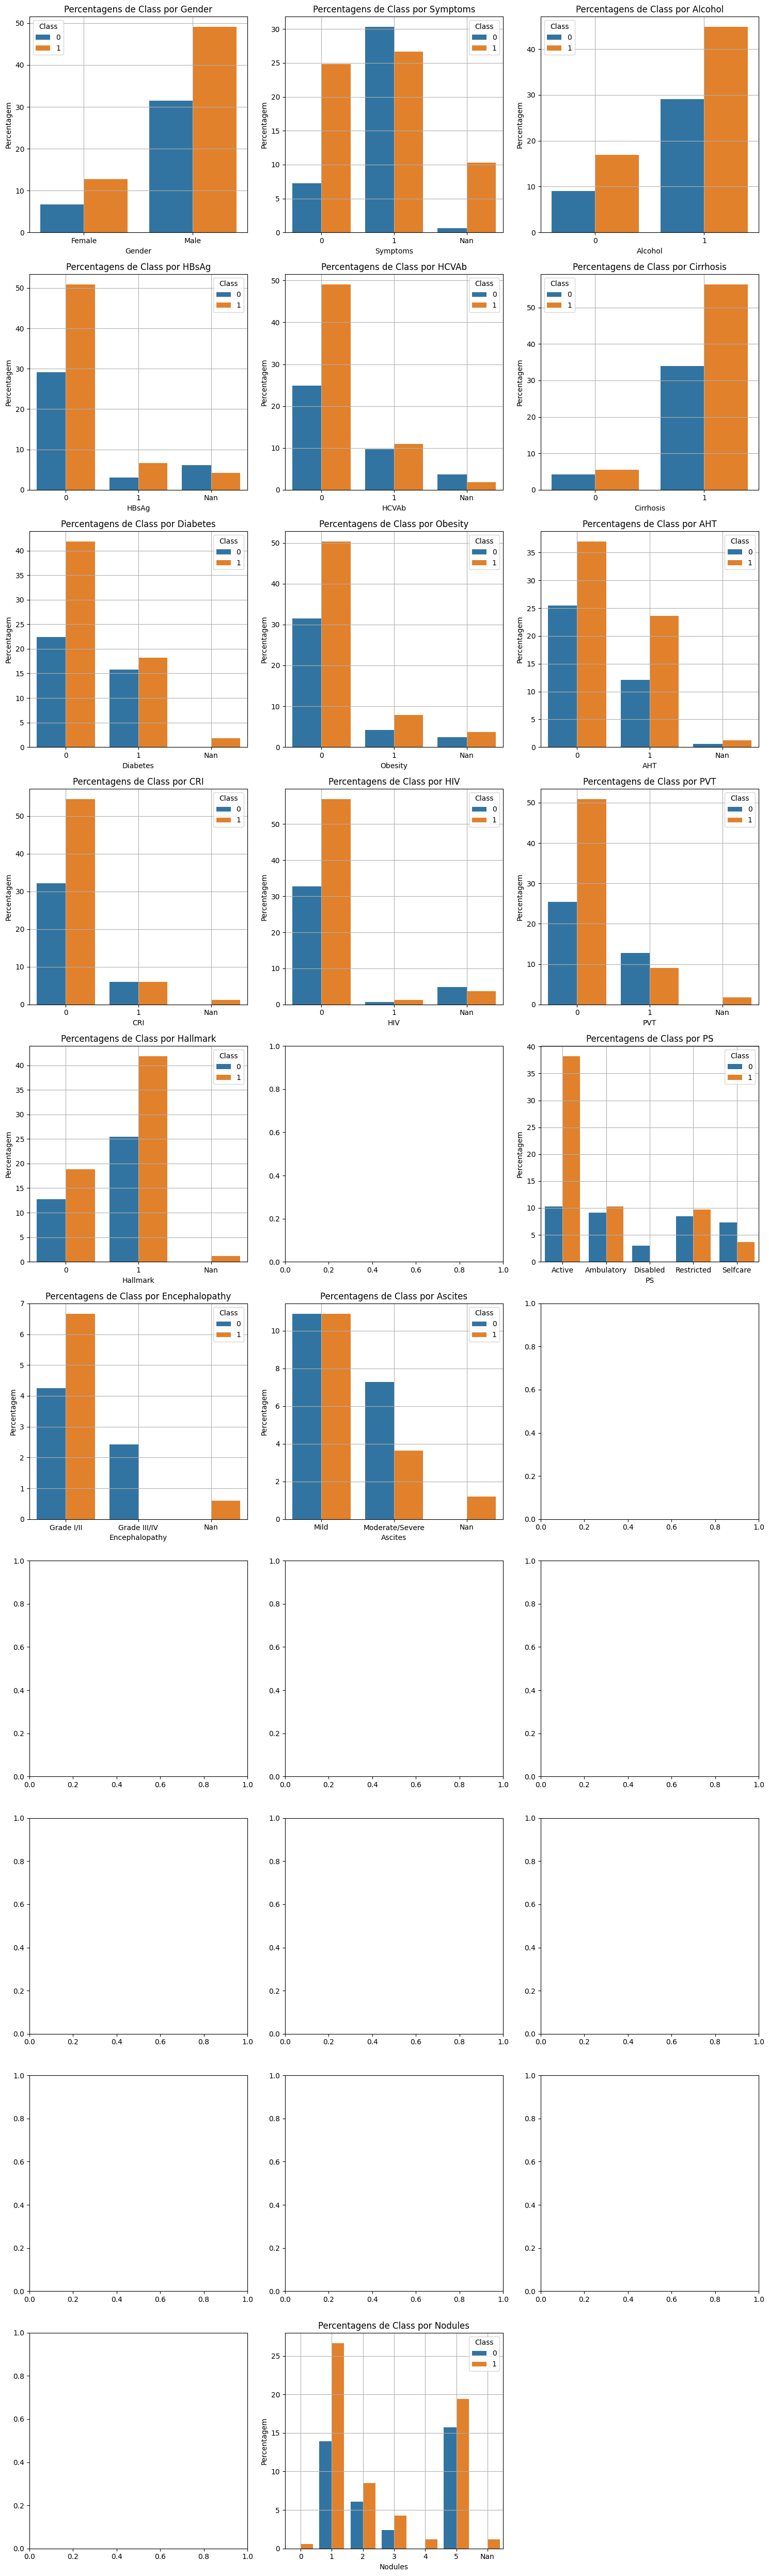

Age:
  1.0 and 20.0: 0.61%
  1.0 and 23.0: 0.61%
  1.0 and 25.0: 0.61%
  0.0 and 27.0: 0.61%
  1.0 and 36.0: 1.21%
  0.0 and 40.0: 0.61%
  1.0 and 40.0: 0.61%
  0.0 and 41.0: 0.61%
  1.0 and 41.0: 0.61%
  0.0 and 43.0: 0.61%
  1.0 and 43.0: 0.61%
  0.0 and 44.0: 0.61%
  0.0 and 45.0: 0.61%
  1.0 and 45.0: 0.61%
  1.0 and 46.0: 0.61%
  1.0 and 47.0: 0.61%
  0.0 and 49.0: 1.21%
  1.0 and 50.0: 1.82%
  0.0 and 51.0: 1.21%
  1.0 and 51.0: 1.21%
  0.0 and 52.0: 1.21%
  1.0 and 52.0: 1.82%
  1.0 and 55.0: 1.82%
  0.0 and 56.0: 0.61%
  1.0 and 56.0: 2.42%
  0.0 and 57.0: 0.61%
  1.0 and 57.0: 1.21%
  1.0 and 58.0: 1.82%
  0.0 and 59.0: 0.61%
  1.0 and 59.0: 1.21%
  0.0 and 60.0: 0.61%
  1.0 and 60.0: 1.82%
  0.0 and 61.0: 1.82%
  1.0 and 61.0: 1.21%
  0.0 and 62.0: 0.61%
  1.0 and 62.0: 3.64%
  0.0 and 63.0: 1.21%
  1.0 and 63.0: 2.42%
  0.0 and 64.0: 1.82%
  1.0 and 64.0: 2.42%
  1.0 and 65.0: 1.82%
  0.0 and 66.0: 1.21%
  1.0 and 66.0: 1.82%
  0.0 and 67.0: 1.21%
  1.0 and 67.0: 3.03%
  0.0

In [39]:
data = pd.read_csv("hcc_dataset_reduced.csv")

def plot_all_diffs(data, target_column):
    # Definir o número máximo de colunas a serem plotadas de uma vez
    max_columns_per_plot = 3

    # Filtrar colunas para não incluir a coluna target
    columns = [col for col in data.columns if col != target_column]
    num_plots = len(columns)
    num_rows = math.ceil(num_plots / max_columns_per_plot)

    fig, axes = plt.subplots(num_rows, max_columns_per_plot, figsize=(15, 5*num_rows))

    total_count = len(data)
    text_output = ""

    for i, column in enumerate(columns):
        unique_values = data[column].nunique()

        if unique_values > 10:
            counts = data.groupby([column, target_column]).size().reset_index(name='count')

            # Calcular a percentagem em relação ao total de linhas
            counts['percentage'] = (counts['count'] / total_count) * 100

            # Gerar o texto
            text_output += f"{column}:\n"
            for index, row in counts.iterrows():
                text_output += f"  {row[target_column]} and {row[column]}: {row['percentage']:.2f}%\n"
            text_output += "\n"

        else:
            counts = data.groupby([column, target_column]).size().reset_index(name='count')

            # Calcular a percentagem em relação ao total de linhas
            counts['percentage'] = (counts['count'] / total_count) * 100

            # Criar o gráfico
            row_index = i // max_columns_per_plot
            col_index = i % max_columns_per_plot
            ax = axes[row_index, col_index]
            sns.barplot(x=column, y='percentage', hue=target_column, data=counts, ax=ax)
            ax.set_title(f"Percentagens de {target_column} por {column}")
            ax.set_xlabel(column)
            ax.set_ylabel('Percentagem')
            ax.grid(True)

    # Remover os subplots não utilizados
    for j in range(i + 1, num_rows * max_columns_per_plot):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    print(text_output)

# Exemplo de uso:
# Suponha que temos um DataFrame data com as colunas 'Class' e outras
data = pd.read_csv("hcc_dataset_reduced.csv")
plot_all_diffs(data, 'Class')

Percentagem de Nan por linha

In [40]:
# Carregar o conjunto de dados
data = pd.read_csv("hcc_dataset_reduced.csv")

# Calcular o número total de colunas no DataFrame
total_colunas = len(data.columns)

# Inicializar o dicionário para armazenar a percentagem de 'Nan' por linha
percentagem_nan_por_linha = {}

# Percorrer as linhas do DataFrame
for indice, linha in data.iterrows():
    # Converter cada célula da linha para string e contar o número de vezes que 'Nan' aparece
    contagem_nan = sum(cell.lower() == 'nan' for cell in linha.astype(str))
    
    # Calcular a percentagem de 'Nan' em relação ao total de células na linha atual
    percentagem = (contagem_nan / total_colunas) * 100
    
    # Armazenar a percentagem de 'Nan' na linha atual no dicionário
    percentagem_nan_por_linha[indice] = percentagem
    
    # Exibir a porcentagem de NaN na linha atual
    print(f"Percentagem de NaN na linha {indice}: {percentagem:.2f}%")

# Ordenar o dicionário pela percentagem de 'Nan' de forma decrescente
linhas_com_mais_nan = sorted(percentagem_nan_por_linha.items(), key=lambda item: item[1], reverse=True)[:10]

# Obter os índices das linhas com maior percentagem de 'Nan'
indices_para_remover = [indice for indice, _ in linhas_com_mais_nan]

# Imprimir as linhas e as respectivas percentagens de 'Nan' que serão removidas
for indice, percentagem in linhas_com_mais_nan:
    print(f"Linha {indice}: {percentagem}% de NaN")

# Remover as linhas do DataFrame
data_limpo = data.drop(indices_para_remover)

# Salvar o novo DataFrame em um novo documento, por exemplo, um arquivo CSV
data_limpo.to_csv('data_limpo_com_mais_nan.csv', index=False, na_rep='None')


Percentagem de NaN na linha 0: 10.00%
Percentagem de NaN na linha 1: 46.67%
Percentagem de NaN na linha 2: 3.33%
Percentagem de NaN na linha 3: 6.67%
Percentagem de NaN na linha 4: 6.67%
Percentagem de NaN na linha 5: 3.33%
Percentagem de NaN na linha 6: 6.67%
Percentagem de NaN na linha 7: 10.00%
Percentagem de NaN na linha 8: 3.33%
Percentagem de NaN na linha 9: 6.67%
Percentagem de NaN na linha 10: 3.33%
Percentagem de NaN na linha 11: 10.00%
Percentagem de NaN na linha 12: 6.67%
Percentagem de NaN na linha 13: 10.00%
Percentagem de NaN na linha 14: 0.00%
Percentagem de NaN na linha 15: 3.33%
Percentagem de NaN na linha 16: 6.67%
Percentagem de NaN na linha 17: 6.67%
Percentagem de NaN na linha 18: 13.33%
Percentagem de NaN na linha 19: 3.33%
Percentagem de NaN na linha 20: 6.67%
Percentagem de NaN na linha 21: 6.67%
Percentagem de NaN na linha 22: 3.33%
Percentagem de NaN na linha 23: 6.67%
Percentagem de NaN na linha 24: 10.00%
Percentagem de NaN na linha 25: 6.67%
Percentagem de 

substitui os Nan por moda

In [41]:
# Carregar o dataset
data = pd.read_csv("data_limpo_com_mais_nan.csv")

# Função para substituir "Nan" pela média ou pela string mais frequente
def substituir_nan(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Para colunas de texto, substituir "Nan" pela string mais frequente
            moda = df[col][df[col] != 'Nan'].mode().iloc[0]
            df[col] = df[col].replace('Nan', moda)
        else:
            # Para colunas numéricas, substituir "Nan" e NaN pela média
            # Primeiro, substitui 'Nan' por np.nan para garantir consistência
            df[col] = pd.to_numeric(df[col], errors='coerce')
            media = df[col].mean()
            df[col] = df[col].replace(np.nan, media)
    return df

# Substituir "Nan" por média ou moda
data = substituir_nan(data)

# Salvar o dataframe com as substituições realizadas
data.to_csv("hcc_dataset_completo.csv", index=False, na_rep='None')

KNN

Melhor número de vizinhos para KNN: 16
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.76      0.95      0.84        20

    accuracy                           0.77        31
   macro avg       0.80      0.70      0.72        31
weighted avg       0.79      0.77      0.75        31

Confusion Matrix for KNN:
[[ 5  6]
 [ 1 19]]
Acurácia média com validação cruzada para KNN: 0.5966666666666667


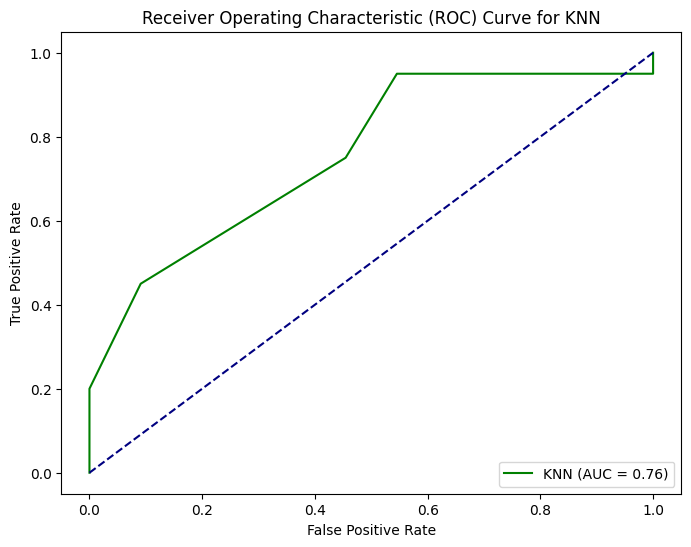

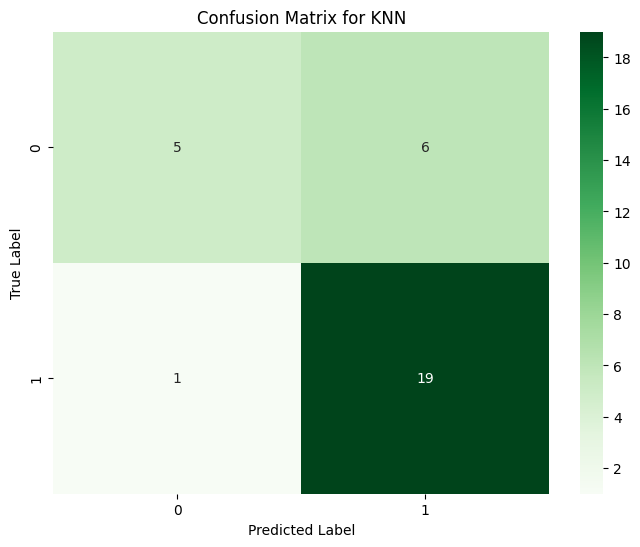

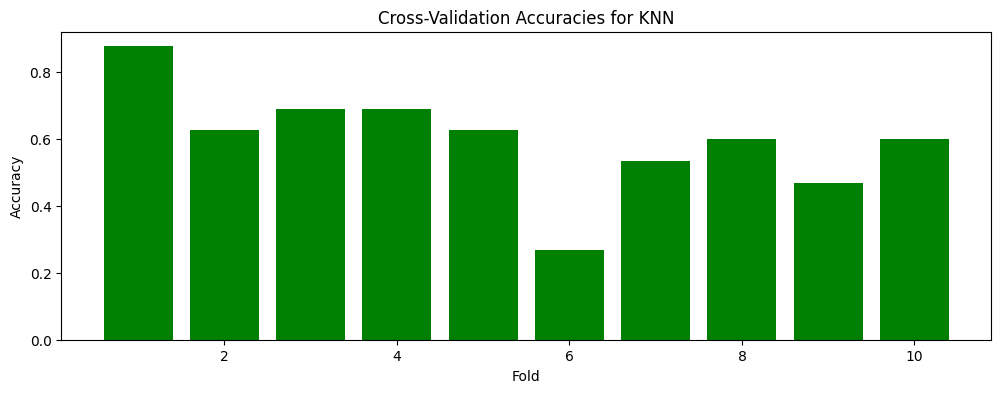

In [42]:
# Carregar o dataset
dataset = pd.read_csv("hcc_dataset_completo.csv")

# Identificar colunas categóricas (neste caso, 'Gender', 'PS', etc.)
categorical_columns = ['Gender', 'PS', 'Encephalopathy', 'Ascites']

# Aplicar Label Encoding para colunas categóricas
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

# Separar as variáveis independentes (X) e a variável dependente (Y)
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

# Dividir os dados em conjuntos de treino e teste (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ajustar os hiperparâmetros do KNN usando GridSearchCV
param_grid = {'n_neighbors': np.arange(1, min(31, len(X_train)))}  # Limiting the range of n_neighbors
knn = KNeighborsClassifier()

knn_gscv = GridSearchCV(knn, param_grid, cv=4) # cv = 4, 6, 10, 12 -> accuracy = 0.77 -> melhor
knn_gscv.fit(X_train, Y_train)

# Melhor número de vizinhos
print(f"Melhor número de vizinhos para KNN: {knn_gscv.best_params_['n_neighbors']}")

# Treinar o classificador KNN com os melhores parâmetros
classifier_knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'])
classifier_knn.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_knn = classifier_knn.predict(X_test)

# Avaliar o modelo
print("Classification Report for KNN:")
print(classification_report(Y_test, y_pred_knn))
print("Confusion Matrix for KNN:")
print(confusion_matrix(Y_test, y_pred_knn))

# Avaliação usando validação cruzada para KNN
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_knn = cross_val_score(classifier_knn, X, Y, cv=cv)
print(f"Acurácia média com validação cruzada para KNN: {cv_scores_knn.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para KNN
y_probs_knn = classifier_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(Y_test, y_probs_knn)
auc_knn = roc_auc_score(Y_test, y_probs_knn)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.show()

# Plotar Matriz de Confusão
conf_matrix = confusion_matrix(Y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotar Gráfico de Barras para Acurácias da Validação Cruzada
plt.figure(figsize=(12, 4))
plt.bar(np.arange(1, 11), cv_scores_knn, color='green')
plt.title("Cross-Validation Accuracies for KNN")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

DT

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.73      0.80      0.76        20

    accuracy                           0.68        31
   macro avg       0.64      0.63      0.63        31
weighted avg       0.67      0.68      0.67        31

Confusion Matrix for Decision Tree:
[[ 5  6]
 [ 4 16]]
Acurácia média com validação cruzada: 0.6266666666666667


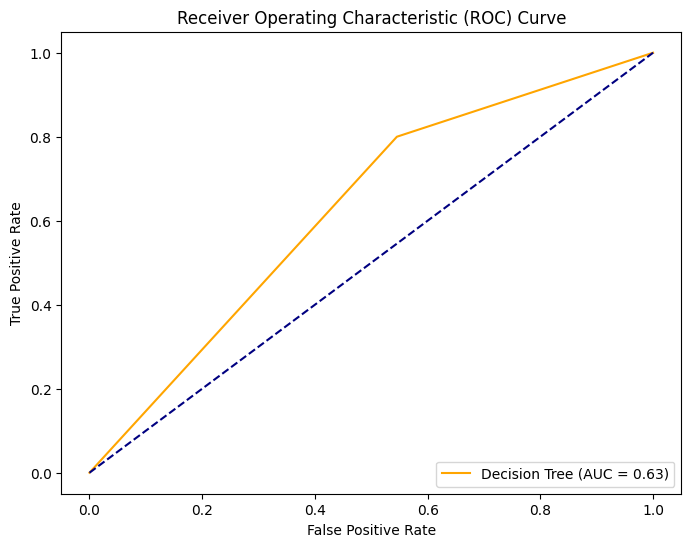

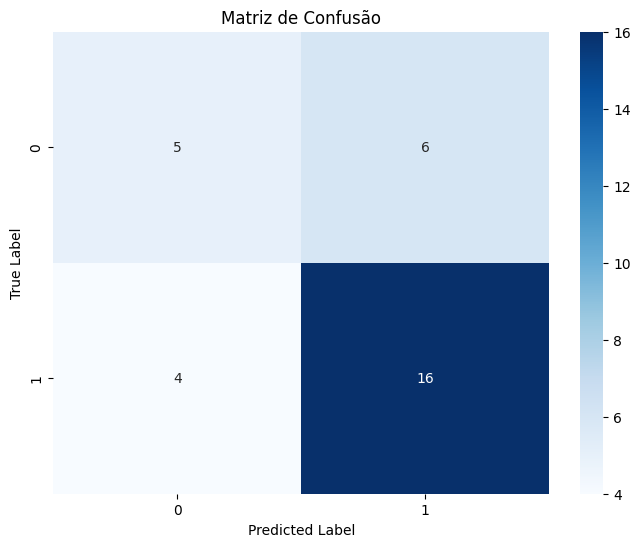

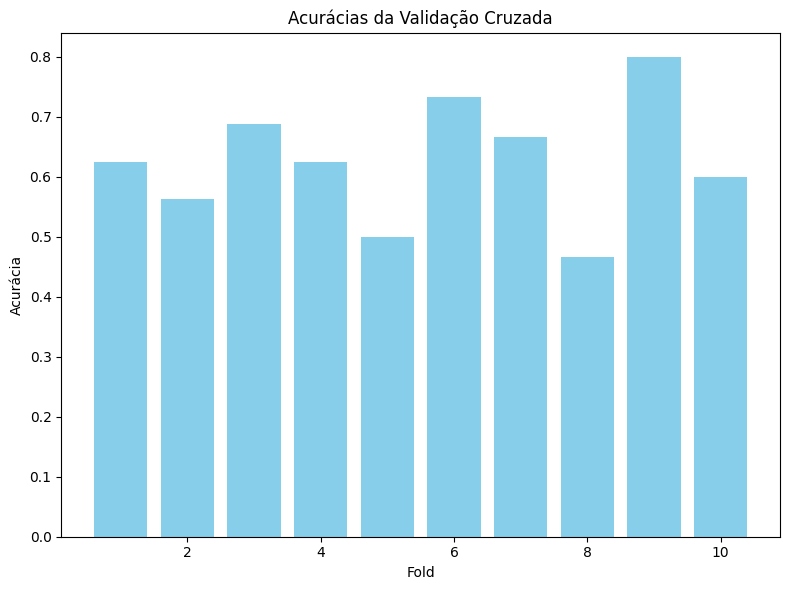

In [43]:
# Carregar o conjunto de dados
dataset = pd.read_csv("hcc_dataset_completo.csv")

# Identificar colunas categóricas
categorical_columns = ['Gender', 'PS', 'Encephalopathy', 'Ascites']

# Aplicar Label Encoding para colunas categóricas
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

# Separar as variáveis independentes (X) e a variável dependente (Y)
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

# Dividir os dados em conjuntos de treino e teste (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar o classificador Decision Tree
classifier_dt = DecisionTreeClassifier(random_state=42)  # Garantir reproducibilidade
classifier_dt.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_dt = classifier_dt.predict(X_test)

# Avaliar o modelo
print("Classification Report for Decision Tree:")
print(classification_report(Y_test, y_pred_dt))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Y_test, y_pred_dt))

# Avaliação usando validação cruzada
cv_scores_dt = cross_val_score(classifier_dt, X, Y, cv=10)
print(f"Acurácia média com validação cruzada: {cv_scores_dt.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para Decision Tree
y_probs_dt = classifier_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_probs_dt)
auc_dt = roc_auc_score(Y_test, y_probs_dt)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='orange', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotar Matriz de Confusão
conf_matrix_dt = confusion_matrix(Y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotar Gráfico de Barras para Acurácias da Validação Cruzada
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, 11), cv_scores_dt, color='skyblue')
plt.title("Acurácias da Validação Cruzada")
plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

Random Forest Classifier

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.76      0.80      0.78        20

    accuracy                           0.71        31
   macro avg       0.68      0.67      0.68        31
weighted avg       0.70      0.71      0.71        31

Confusion Matrix for Random Forest:
[[ 6  5]
 [ 4 16]]
Acurácia média com validação cruzada (Random Forest): 0.6775


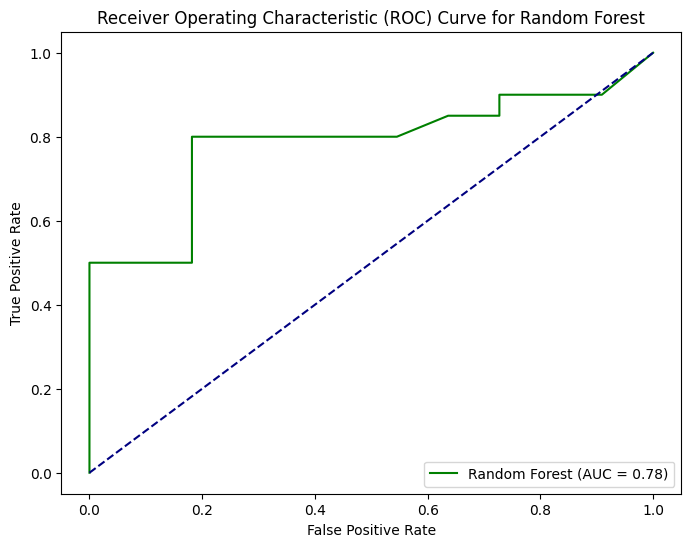

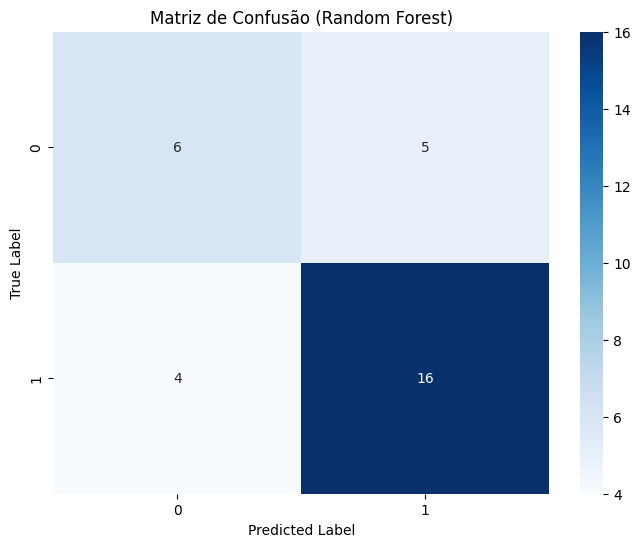

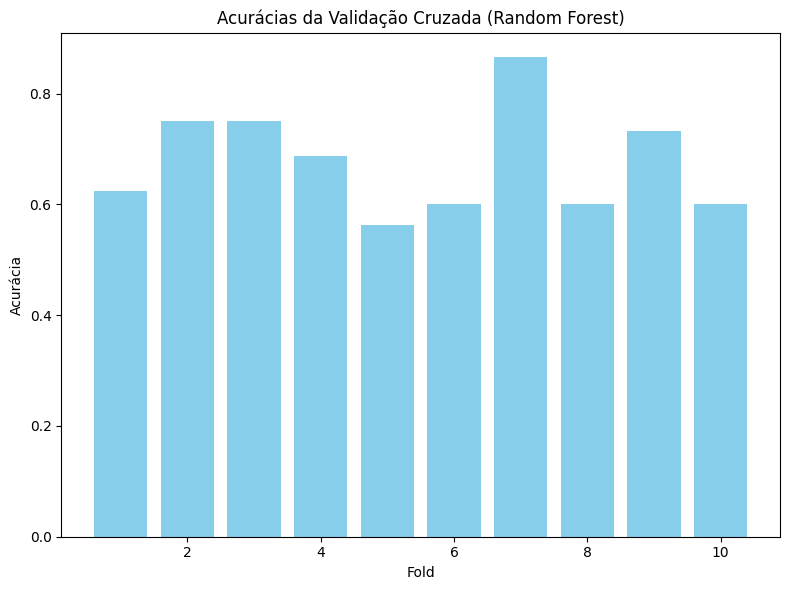

In [44]:
# Treinar o classificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)  # Garantir reproducibilidade
rf_classifier.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_rf = rf_classifier.predict(X_test)

# Avaliar o modelo
print("Classification Report for Random Forest:")
print(classification_report(Y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(Y_test, y_pred_rf))

# Avaliação usando validação cruzada
cv_scores_rf = cross_val_score(rf_classifier, X, Y, cv=10)
print(f"Acurácia média com validação cruzada (Random Forest): {cv_scores_rf.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para Random Forest
y_probs_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_probs_rf)
auc_rf = roc_auc_score(Y_test, y_probs_rf)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

# Plotar Matriz de Confusão
conf_matrix_rf = confusion_matrix(Y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotar Gráfico de Barras para Acurácias da Validação Cruzada
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, 11), cv_scores_rf, color='skyblue')
plt.title("Acurácias da Validação Cruzada (Random Forest)")
plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

DATA EVALUATION: KNN e DT

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.73      0.80      0.76        20

    accuracy                           0.68        31
   macro avg       0.64      0.63      0.63        31
weighted avg       0.67      0.68      0.67        31

Confusion Matrix for Decision Tree:
[[ 5  6]
 [ 4 16]]
Acurácia média com validação cruzada para Decision Tree: 0.6254166666666666
Melhor número de vizinhos para KNN: 16
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.76      0.95      0.84        20

    accuracy                           0.77        31
   macro avg       0.80      0.70      0.72        31
weighted avg       0.79      0.77      0.75        31

Confusion Matrix for KNN:
[[ 5  6]
 [ 1 19]]
Acurácia média com validação cruzada para KNN: 0.5966666666

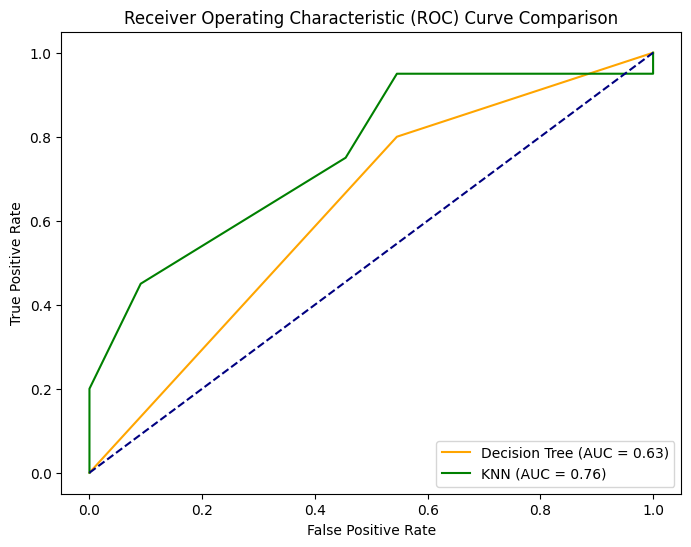

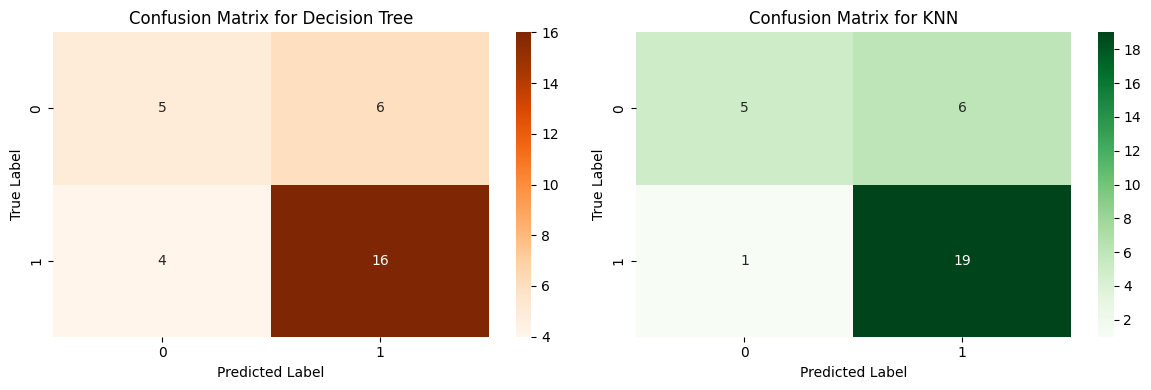

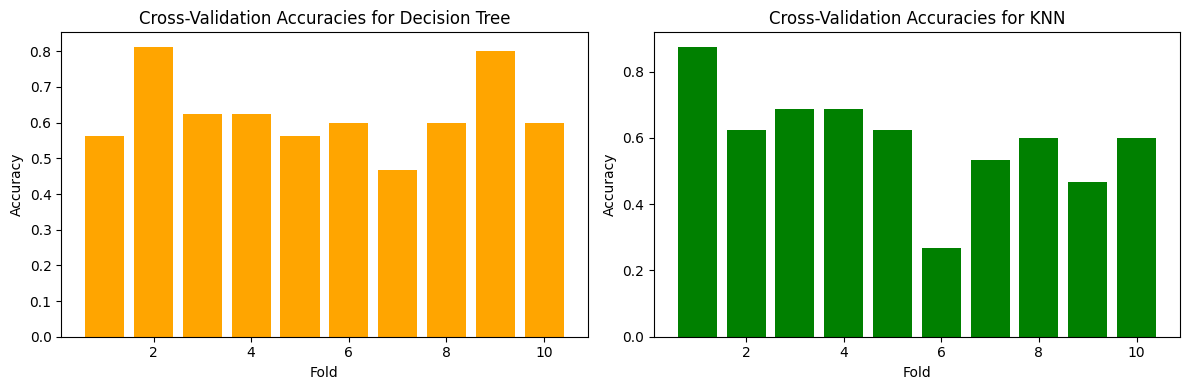

In [45]:
# Carregar o conjunto de dados
dataset = pd.read_csv("hcc_dataset_completo.csv")

# Identificar colunas categóricas
categorical_columns = ['Gender', 'PS', 'Encephalopathy', 'Ascites']

# Aplicar Label Encoding para colunas categóricas
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

# Separar as variáveis independentes (X) e a variável dependente (Y)
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

# Dividir os dados em conjuntos de treino e teste (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar o classificador Decision Tree
classifier_dt = DecisionTreeClassifier(random_state=42)
classifier_dt.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste para Decision Tree
y_pred_dt = classifier_dt.predict(X_test)

# Avaliar o modelo Decision Tree
print("Classification Report for Decision Tree:")
print(classification_report(Y_test, y_pred_dt))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Y_test, y_pred_dt))

# Avaliação usando validação cruzada para Decision Tree
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_dt = cross_val_score(classifier_dt, X, Y, cv=cv)
print(f"Acurácia média com validação cruzada para Decision Tree: {cv_scores_dt.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para Decision Tree
y_probs_dt = classifier_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_probs_dt)
auc_dt = roc_auc_score(Y_test, y_probs_dt)

# Ajustar os hiperparâmetros do KNN usando GridSearchCV
param_grid = {'n_neighbors': np.arange(1, min(31, len(X_train)))}
knn = KNeighborsClassifier()

knn_gscv = GridSearchCV(knn, param_grid, cv=4)
knn_gscv.fit(X_train, Y_train)

# Melhor número de vizinhos
print(f"Melhor número de vizinhos para KNN: {knn_gscv.best_params_['n_neighbors']}")

# Treinar o classificador KNN com os melhores parâmetros
classifier_knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'])
classifier_knn.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste para KNN
y_pred_knn = classifier_knn.predict(X_test)

# Avaliar o modelo KNN
print("Classification Report for KNN:")
print(classification_report(Y_test, y_pred_knn))
print("Confusion Matrix for KNN:")
print(confusion_matrix(Y_test, y_pred_knn))

# Avaliação usando validação cruzada para KNN
cv_scores_knn = cross_val_score(classifier_knn, X, Y, cv=cv)
print(f"Acurácia média com validação cruzada para KNN: {cv_scores_knn.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para KNN
y_probs_knn = classifier_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(Y_test, y_probs_knn)
auc_knn = roc_auc_score(Y_test, y_probs_knn)

# Comparação de resultados
metrics = ['precision', 'recall', 'f1-score']
dt_classification_report = classification_report(Y_test, y_pred_dt, output_dict=True)
knn_classification_report = classification_report(Y_test, y_pred_knn, output_dict=True)

# Criar DataFrame para métricas
metrics_data = {
    'Metric': metrics,
    'Decision Tree': [dt_classification_report['weighted avg'][metric] for metric in metrics],
    'KNN': [knn_classification_report['weighted avg'][metric] for metric in metrics]
}

metrics_df = pd.DataFrame(metrics_data)

# Adicionar coluna para AUCs
metrics_df.loc[len(metrics_df)] = ['AUC', auc_dt, auc_knn]

print("Comparison of Classification Metrics:")
print(metrics_df)

# Plotar as curvas ROC dos dois classificadores em um único gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='orange', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Plotar Matriz de Confusão para Decision Tree
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(Y_test, y_pred_dt), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plotar Matriz de Confusão para KNN
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(Y_test, y_pred_knn), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

# Plotar Gráfico de Barras para Acurácias da Validação Cruzada
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(np.arange(1, 11), cv_scores_dt, color='orange')
plt.title("Cross-Validation Accuracies for Decision Tree")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, 11), cv_scores_knn, color='green')
plt.title("Cross-Validation Accuracies for KNN")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

DATA EVALUATION: DT, KNN e RF

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.73      0.80      0.76        20

    accuracy                           0.68        31
   macro avg       0.64      0.63      0.63        31
weighted avg       0.67      0.68      0.67        31

Confusion Matrix for Decision Tree:
[[ 5  6]
 [ 4 16]]
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.76      0.95      0.84        20

    accuracy                           0.77        31
   macro avg       0.80      0.70      0.72        31
weighted avg       0.79      0.77      0.75        31

Confusion Matrix for KNN:
[[ 5  6]
 [ 1 19]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.76 

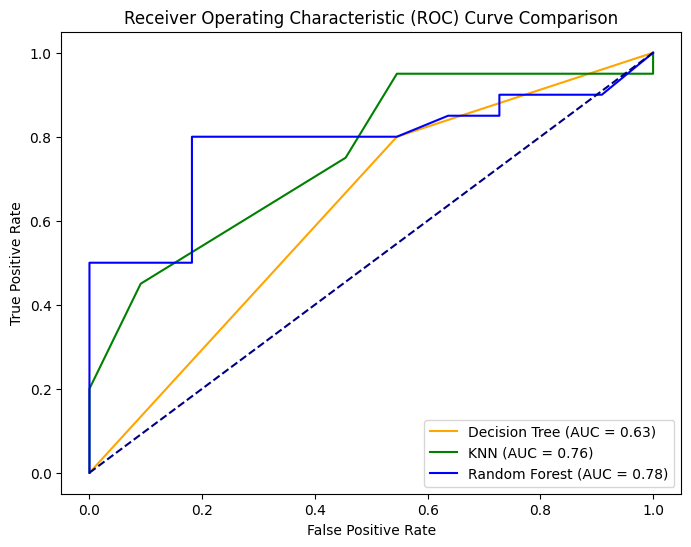

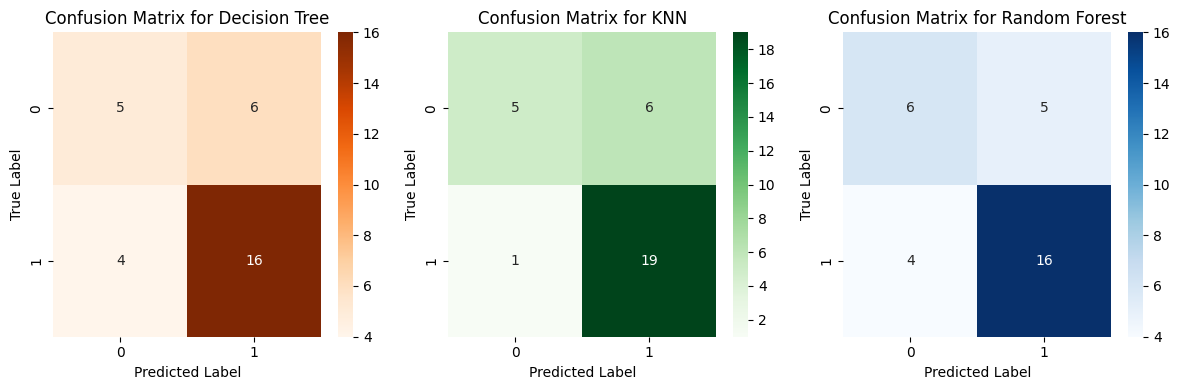

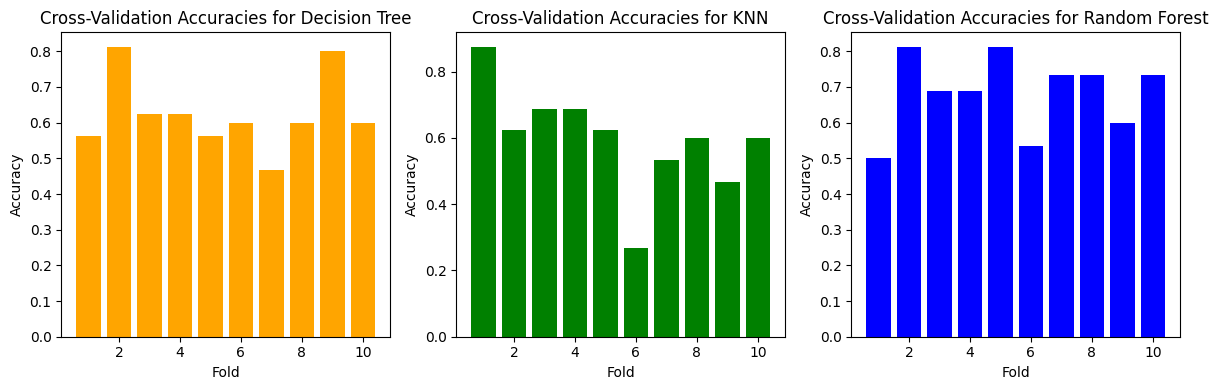

In [46]:
# Treinar o classificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste para Random Forest
y_pred_rf = rf_classifier.predict(X_test)

# Imprimir a tabela para Decision Tree
print("Classification Report for Decision Tree:")
print(classification_report(Y_test, y_pred_dt))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(Y_test, y_pred_dt))

# Imprimir a tabela para KNN
print("Classification Report for KNN:")
print(classification_report(Y_test, y_pred_knn))
print("Confusion Matrix for KNN:")
print(confusion_matrix(Y_test, y_pred_knn))

# Imprimir a tabela para Random Forest
print("Classification Report for Random Forest:")
print(classification_report(Y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(Y_test, y_pred_rf))


# Avaliação usando validação cruzada para Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, Y, cv=cv)
print(f"Acurácia média com validação cruzada para Random Forest: {cv_scores_rf.mean()}")

# Calcular a Curva ROC e a Área sob a Curva (AUC) para Random Forest
y_probs_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_probs_rf)
auc_rf = roc_auc_score(Y_test, y_probs_rf)

# Comparação de resultados
rf_classification_report = classification_report(Y_test, y_pred_rf, output_dict=True)

# Criar DataFrame para métricas
metrics_data = {
    'Metric': metrics,
    'Decision Tree': [dt_classification_report['weighted avg'][metric] for metric in metrics],
    'KNN': [knn_classification_report['weighted avg'][metric] for metric in metrics],
    'Random Forest': [rf_classification_report['weighted avg'][metric] for metric in metrics]  # Adicionando Random Forest
}

metrics_df = pd.DataFrame(metrics_data)

# Adicionar linha para AUCs
metrics_df.loc[len(metrics_df)] = ['AUC', auc_dt, auc_knn, auc_rf]

print("Comparison of Classification Metrics:")
print(metrics_df)


# Plotar as curvas ROC dos três classificadores em um único gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='orange', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Plotar Matriz de Confusão para Random Forest
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(Y_test, y_pred_dt), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix for Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plotar Matriz de Confusão para KNN
plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(Y_test, y_pred_knn), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix for KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plotar Matriz de Confusão para Random Forest
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(Y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

# Plotar Gráfico de Barras para Acurácias da Validação Cruzada
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(np.arange(1, 11), cv_scores_dt, color='orange')
plt.title("Cross-Validation Accuracies for Decision Tree")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.bar(np.arange(1, 11), cv_scores_knn, color='green')
plt.title("Cross-Validation Accuracies for KNN")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.bar(np.arange(1, 11), cv_scores_rf, color='blue')
plt.title("Cross-Validation Accuracies for Random Forest")
plt.xlabel("Fold")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

PERFORMANCE DURING LEARING

Learning Curve Data:
   Train Size  Decision Tree Train Score  Decision Tree Test Score  \
0         0.1                        1.0                  0.580645   
1         0.2                        1.0                  0.709677   
2         0.3                        1.0                  0.516129   
3         0.4                        1.0                  0.612903   
4         0.5                        1.0                  0.677419   
5         0.6                        1.0                  0.612903   
6         0.7                        1.0                  0.612903   
7         0.8                        1.0                  0.677419   
8         0.9                        1.0                  0.645161   
9         1.0                        1.0                  0.677419   

   KNN Train Score  KNN Test Score  Random Forest Train Score  \
0         0.833333        0.419355                        1.0   
1         0.708333        0.645161                        1.0   
2         0.8

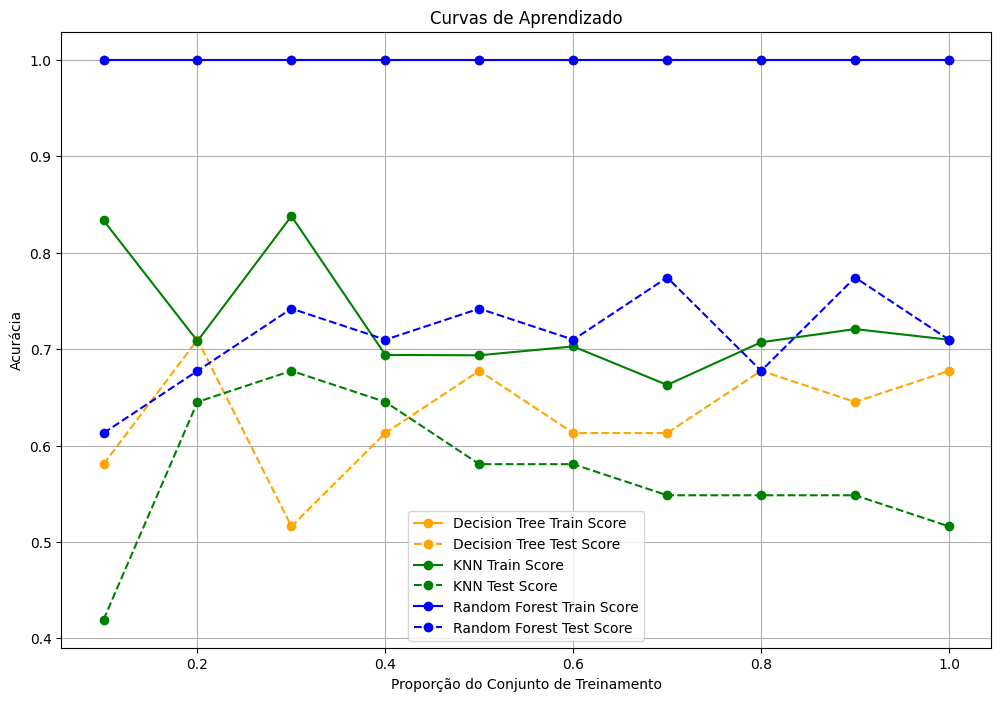

In [47]:
# Inicializar os classificadores
dt_classifier = DecisionTreeClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
rf_classifier = RandomForestClassifier(random_state=42)

# Treinar os classificadores
dt_classifier.fit(X_train, Y_train)
knn_classifier.fit(X_train, Y_train)
rf_classifier.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
y_pred_dt = dt_classifier.predict(X_test)
y_pred_knn = knn_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)

# Calcular curvas ROC e AUCs
y_probs_dt = dt_classifier.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(Y_test, y_probs_dt)
auc_dt = roc_auc_score(Y_test, y_probs_dt)

y_probs_knn = knn_classifier.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(Y_test, y_probs_knn)
auc_knn = roc_auc_score(Y_test, y_probs_knn)

y_probs_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_probs_rf)
auc_rf = roc_auc_score(Y_test, y_probs_rf)

# Avaliação usando validação cruzada
cv_scores_dt = cross_val_score(dt_classifier, X, Y, cv=10)
cv_scores_knn = cross_val_score(knn_classifier, X, Y, cv=10)
cv_scores_rf = cross_val_score(rf_classifier, X, Y, cv=10)

# Tabelas de performance durante o aprendizado
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_dt, test_scores_dt = [], []
train_scores_knn, test_scores_knn = [], []
train_scores_rf, test_scores_rf = [], []

for train_size in train_sizes:
    X_train_part, Y_train_part = X_train[:int(len(X_train) * train_size)], Y_train[:int(len(Y_train) * train_size)]
    
    dt_classifier.fit(X_train_part, Y_train_part)
    knn_classifier.fit(X_train_part, Y_train_part)
    rf_classifier.fit(X_train_part, Y_train_part)
    
    train_scores_dt.append(dt_classifier.score(X_train_part, Y_train_part))
    test_scores_dt.append(dt_classifier.score(X_test, Y_test))
    
    train_scores_knn.append(knn_classifier.score(X_train_part, Y_train_part))
    test_scores_knn.append(knn_classifier.score(X_test, Y_test))
    
    train_scores_rf.append(rf_classifier.score(X_train_part, Y_train_part))
    test_scores_rf.append(rf_classifier.score(X_test, Y_test))

learning_curve_data = {
    'Train Size': train_sizes,
    'Decision Tree Train Score': train_scores_dt,
    'Decision Tree Test Score': test_scores_dt,
    'KNN Train Score': train_scores_knn,
    'KNN Test Score': test_scores_knn,
    'Random Forest Train Score': train_scores_rf,
    'Random Forest Test Score': test_scores_rf
}

learning_curve_df = pd.DataFrame(learning_curve_data)
print("Learning Curve Data:")
print(learning_curve_df)

# Plotar as curvas de aprendizado
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_scores_dt, label='Decision Tree Train Score', marker='o', color='orange')
plt.plot(train_sizes, test_scores_dt, label='Decision Tree Test Score', marker='o', linestyle='--', color='orange')

plt.plot(train_sizes, train_scores_knn, label='KNN Train Score', marker='o', color='green')
plt.plot(train_sizes, test_scores_knn, label='KNN Test Score', marker='o', linestyle='--', color='green')

plt.plot(train_sizes, train_scores_rf, label='Random Forest Train Score', marker='o', color='blue')
plt.plot(train_sizes, test_scores_rf, label='Random Forest Test Score', marker='o', linestyle='--', color='blue')

plt.xlabel('Proporção do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.title('Curvas de Aprendizado')
plt.legend()
plt.grid(True)
plt.show()

Smote & Down-Sampling

In [48]:
def load_data(file_path):
    """Carrega o conjunto de dados."""
    dataset = pd.read_csv(file_path)
    return dataset

# Carregar o conjunto de dados
file_path = "hcc_dataset_completo.csv"
dataset = load_data(file_path)

# Definir as colunas de características (X) e a coluna de destino (Y)
X = dataset.drop(columns=['Class', 'Gender', 'PS', 'Encephalopathy', 'Ascites'])
Y = dataset['Class']

# Definir as técnicas de balanceamento de dados
data_balancing_techniques = {
    'Original': None,  # Sem balanceamento
    'Down-sampling': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    # Adicionar mais técnicas conforme necessário
}

# Treinar e avaliar modelos para cada técnica de balanceamento
for column in X.columns:
    print(f"--- Avaliação para a coluna '{column}' ---")
    for technique_name, sampler in data_balancing_techniques.items():
        if sampler is not None:
            # Aplicar a técnica de balanceamento de dados
            X_balanced, Y_balanced = sampler.fit_resample(X[[column]].astype(np.float64), Y)
        else:
            # Usar o conjunto de dados original
            X_balanced, Y_balanced = X[[column]].astype(np.float64), Y
        
        # Treinar o modelo (usaremos uma Decision Tree para este exemplo)
        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(X_balanced, Y_balanced)
        
        # Fazer previsões
        y_pred = classifier.predict(X[[column]])
        
        # Avaliar o modelo
        accuracy = accuracy_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        
        # Exibir os resultados da avaliação
        print(f"Avaliação para {technique_name}:")
        print(f"   Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
    print()


--- Avaliação para a coluna 'Symptoms' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.57, Precision: 0.76, Recall: 0.42, F1-score: 0.54
Avaliação para SMOTE:
   Accuracy: 0.57, Precision: 0.76, Recall: 0.42, F1-score: 0.54

--- Avaliação para a coluna 'Alcohol' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.46, Precision: 0.63, Recall: 0.26, F1-score: 0.37
Avaliação para SMOTE:
   Accuracy: 0.46, Precision: 0.63, Recall: 0.26, F1-score: 0.37

--- Avaliação para a coluna 'HBsAg' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.57, Precision: 0.59, Recall: 0.89, F1-score: 0.71
Avaliação para SMOTE:
   Accuracy: 0.43, Precision: 0.67, Recall: 0.11, F1-score: 0.19

--- Avaliação para a coluna 'HCVAb' ---
Avaliação para O

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avaliação para Down-sampling:
   Accuracy: 0.52, Precision: 0.66, Recall: 0.40, F1-score: 0.50
Avaliação para SMOTE:
   Accuracy: 0.52, Precision: 0.66, Recall: 0.40, F1-score: 0.50

--- Avaliação para a coluna 'CRI' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.59, Precision: 0.61, Recall: 0.89, F1-score: 0.72
Avaliação para SMOTE:
   Accuracy: 0.59, Precision: 0.61, Recall: 0.89, F1-score: 0.72

--- Avaliação para a coluna 'HIV' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.40, Precision: 0.00, Recall: 0.00, F1-score: 0.00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Avaliação para SMOTE:
   Accuracy: 0.41, Precision: 0.67, Recall: 0.02, F1-score: 0.04

--- Avaliação para a coluna 'PVT' ---
Avaliação para Original:
   Accuracy: 0.65, Precision: 0.66, Recall: 0.85, F1-score: 0.74
Avaliação para Down-sampling:
   Accuracy: 0.65, Precision: 0.66, Recall: 0.85, F1-score: 0.74
Avaliação para SMOTE:
   Accuracy: 0.65, Precision: 0.66, Recall: 0.85, F1-score: 0.74

--- Avaliação para a coluna 'Hallmark' ---
Avaliação para Original:
   Accuracy: 0.60, Precision: 0.60, Recall: 1.00, F1-score: 0.75
Avaliação para Down-sampling:
   Accuracy: 0.54, Precision: 0.60, Recall: 0.69, F1-score: 0.64
Avaliação para SMOTE:
   Accuracy: 0.54, Precision: 0.60, Recall: 0.69, F1-score: 0.64

--- Avaliação para a coluna 'Age' ---
Avaliação para Original:
   Accuracy: 0.73, Precision: 0.76, Recall: 0.81, F1-score: 0.78
Avaliação para Down-sampling:
   Accuracy: 0.68, Precision: 0.79, Recall: 0.63, F1-score: 0.70
Avaliação para SMOTE:
   Accuracy: 0.73, Precision: 0.76, Reca

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


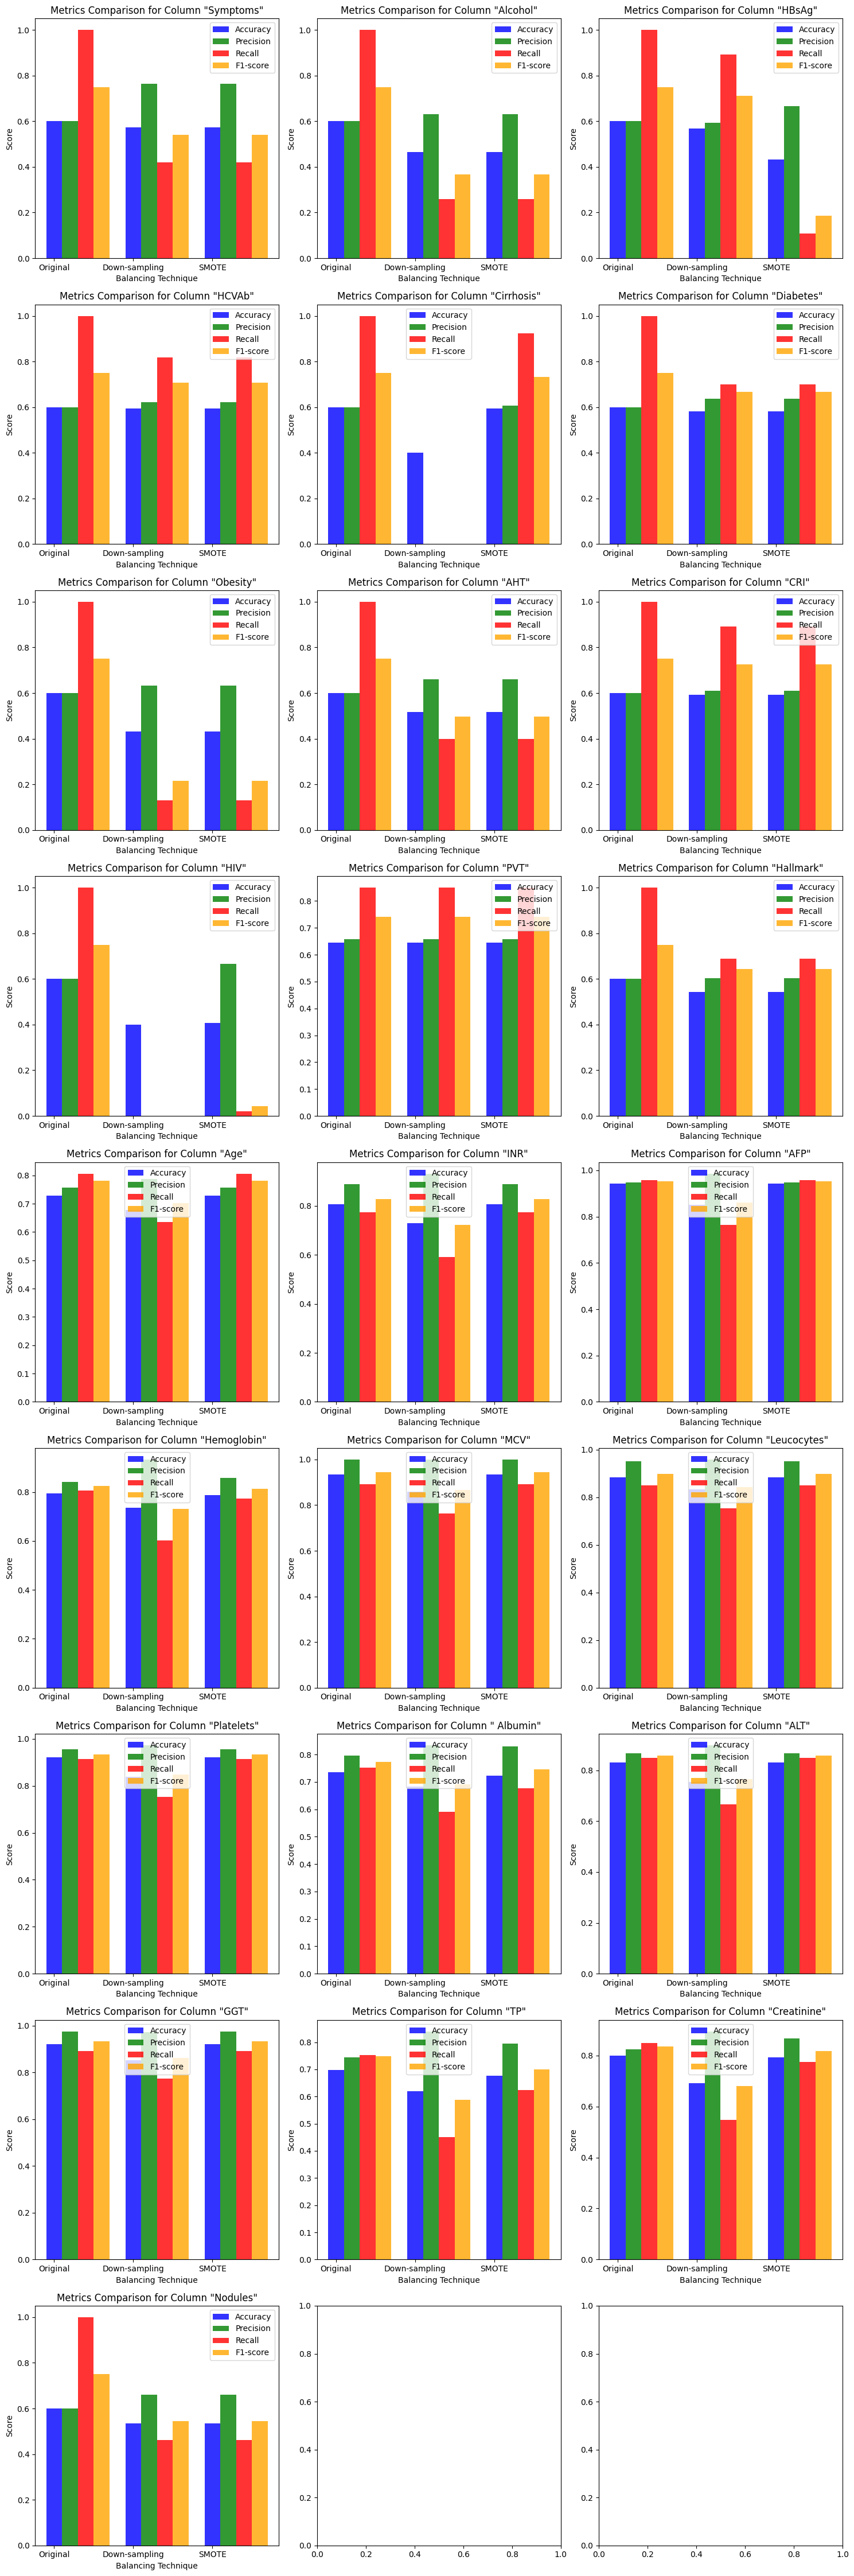

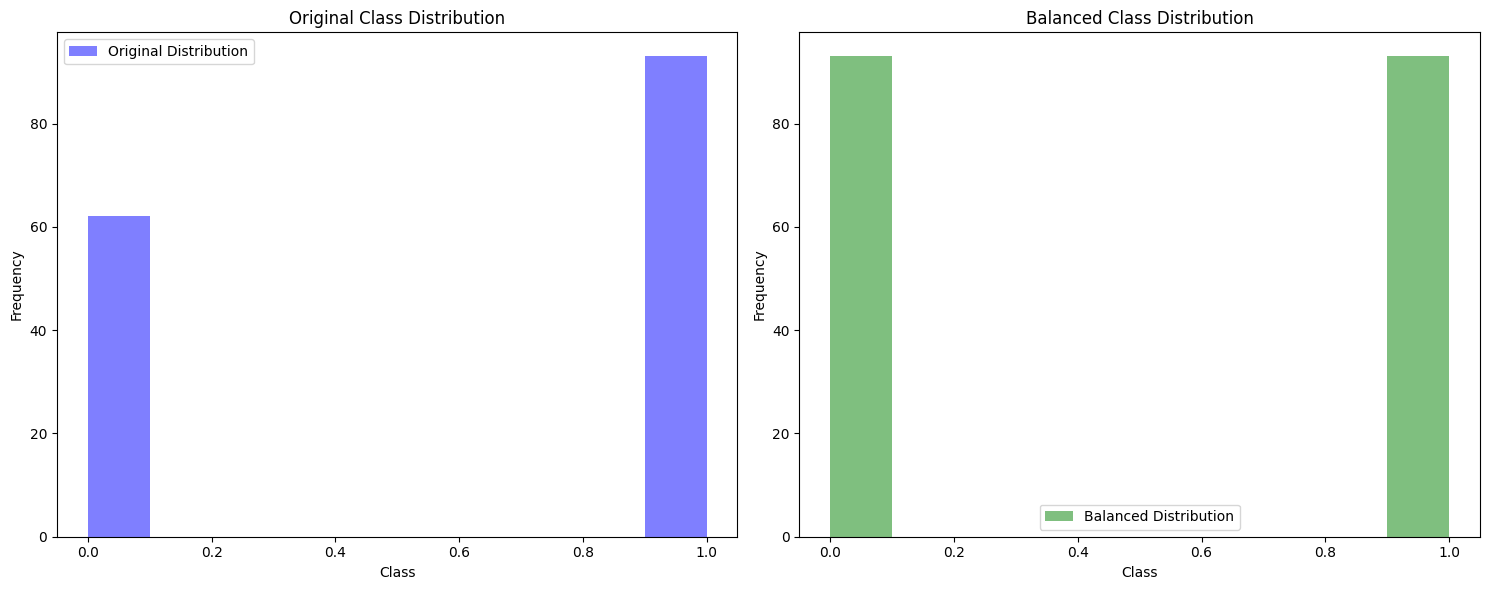

In [49]:
# Gráficos de barras para métricas de avaliação
num_columns = len(X.columns)
num_techniques = len(data_balancing_techniques)

num_rows = (num_columns + 2) // 3  # Número de linhas necessário para acomodar todos os gráficos
num_cols = min(num_columns, 3)  # Máximo de 3 gráficos por linha

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(X.columns):
    row = i // num_cols
    col = i % num_cols
    
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}
    colors = ['blue', 'green', 'red', 'orange']  # Cores diferentes para cada métrica
    
    for technique_name, sampler in data_balancing_techniques.items():
        if sampler is not None:
            X_balanced, Y_balanced = sampler.fit_resample(X[[column]].astype(np.float64), Y)
        else:
            X_balanced, Y_balanced = X[[column]].astype(np.float64), Y
        
        classifier = DecisionTreeClassifier(random_state=42)
        classifier.fit(X_balanced, Y_balanced)
        
        y_pred = classifier.predict(X[[column]])
        
        accuracy = accuracy_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        
        metrics['Accuracy'].append(accuracy)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1-score'].append(f1)
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    for j, (metric, values) in enumerate(metrics.items()):
        ax.bar(np.arange(len(values)) + j * 0.2, values, color=colors[j], width=0.2, alpha=0.8, label=metric)
    ax.set_xticks(range(len(data_balancing_techniques)))
    ax.set_xticklabels(list(data_balancing_techniques.keys()))
    ax.set_xlabel('Balancing Technique')
    ax.set_ylabel('Score')
    ax.set_title(f'Metrics Comparison for Column "{column}"')
    ax.legend()

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

# Histogramas para distribuição das classes
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(Y, color='blue', alpha=0.5, label='Original Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Original Class Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Y_balanced, color='green', alpha=0.5, label='Balanced Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Balanced Class Distribution')
plt.legend()

plt.tight_layout()
plt.show()

Características mais importantes para o resultado

### Avaliando algoritmo: Decision Tree ###
--- Método de particionamento: holdout ---
Accuracy: 0.64, Precision: 0.66, Recall: 0.78, F1-score: 0.71
--- Método de particionamento: kfold ---
Accuracy (média): 0.58
--- Método de particionamento: leave-one-out ---
Accuracy (média): 0.61
### Avaliando algoritmo: Random Forest ###
--- Método de particionamento: holdout ---
Accuracy: 0.64, Precision: 0.65, Recall: 0.81, F1-score: 0.72
--- Método de particionamento: kfold ---
Accuracy (média): 0.72
--- Método de particionamento: leave-one-out ---
Accuracy (média): 0.65
### Avaliando algoritmo: K-Nearest Neighbors ###
--- Método de particionamento: holdout ---
Accuracy: 0.60, Precision: 0.61, Recall: 0.81, F1-score: 0.70
--- Método de particionamento: kfold ---
Accuracy (média): 0.56
--- Método de particionamento: leave-one-out ---
Accuracy (média): 0.55

Características mais importantes para o resultado:
       Feature  Importance
19     Albumin    0.131037
14         AFP    0.108609
15  Hemog

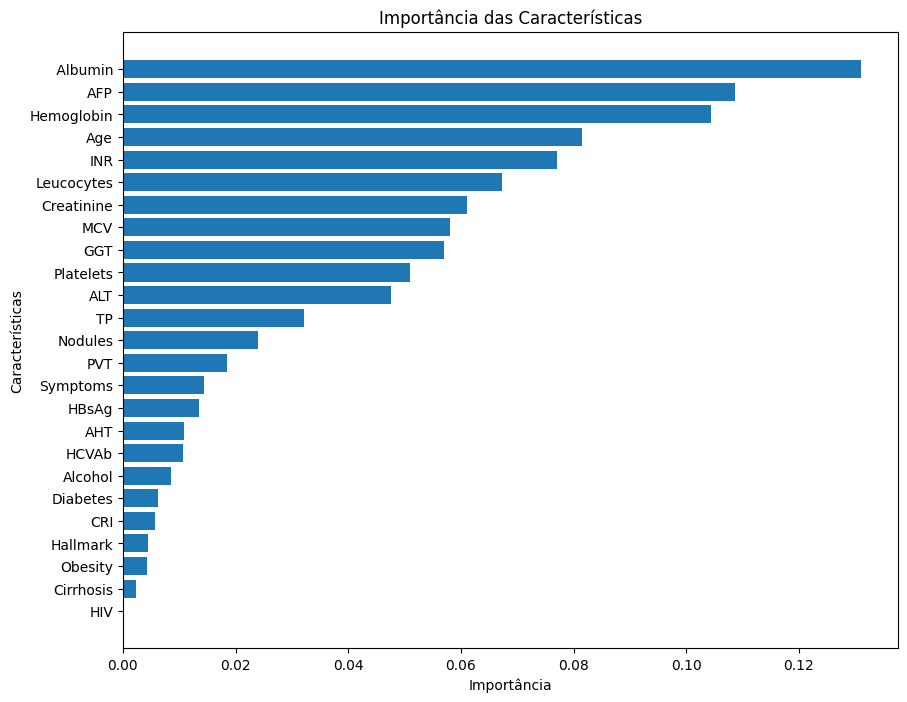

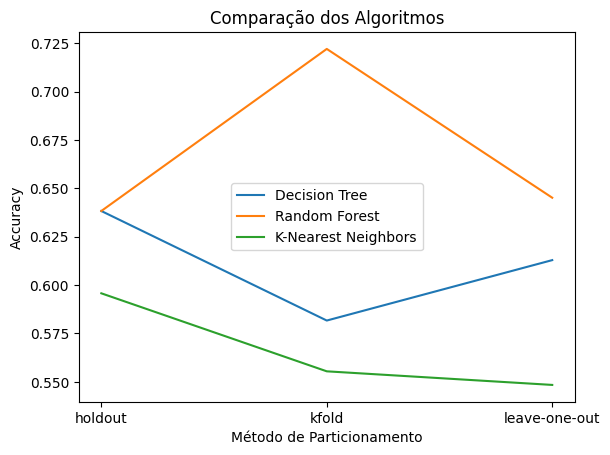

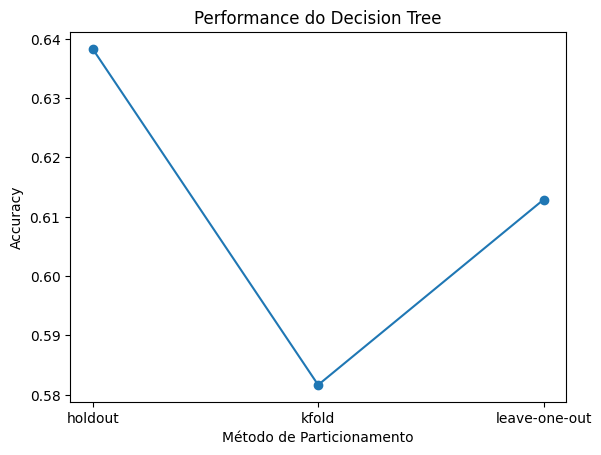

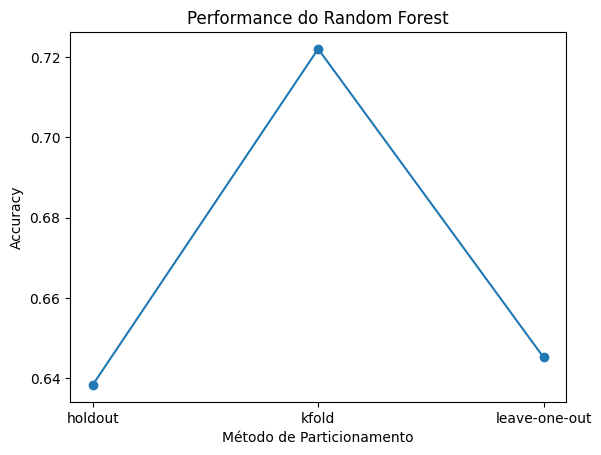

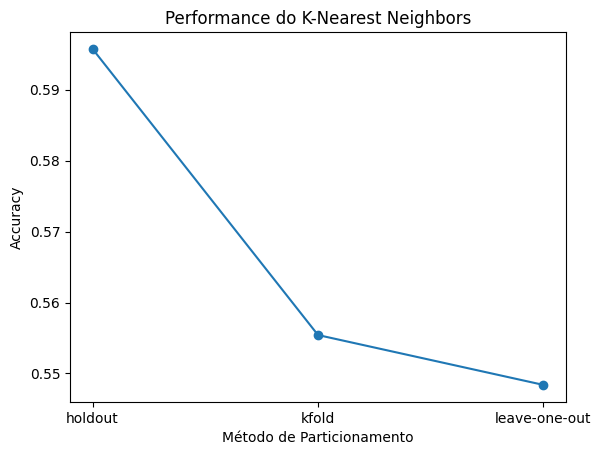

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def load_data(file_path):
    """Carrega o conjunto de dados."""
    dataset = pd.read_csv(file_path)
    return dataset

def evaluate_feature_importance(X, Y):
    """Avalia a importância das características usando RandomForestClassifier."""
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, Y_train)
    y_pred = classifier.predict(X_test)
    feature_importances = classifier.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    return feature_importance_df

def evaluate_model(classifier, X, Y, partitioning_method):
    """Avalia o modelo com diferentes métodos de particionamento."""
    if partitioning_method == 'holdout':
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
        classifier.fit(X_train, Y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        precision = precision_score(Y_test, y_pred)
        recall = recall_score(Y_test, y_pred)
        f1 = f1_score(Y_test, y_pred)
        return accuracy, precision, recall, f1
    elif partitioning_method == 'kfold':
        scores = cross_val_score(classifier, X, Y, cv=10, scoring='accuracy')
        return np.mean(scores), None, None, None
    elif partitioning_method == 'leave-one-out':
        loo = LeaveOneOut()
        scores = cross_val_score(classifier, X, Y, cv=loo, scoring='accuracy')
        return np.mean(scores), None, None, None

def hyperparameter_tuning(classifier, param_grid, X, Y):
    """Realiza a otimização de hiperparâmetros usando GridSearchCV."""
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, Y)
    return grid_search.best_estimator_

# Carregar o conjunto de dados
file_path = "hcc_dataset_completo.csv"
dataset = load_data(file_path)

# Definir as colunas de características (X) e a coluna de destino (Y)
X = dataset.drop(columns=['Class', 'Gender', 'PS', 'Encephalopathy', 'Ascites'])
Y = dataset['Class']

# Algoritmos a serem testados
algorithms = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Grid search parameter grids
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
}

# Métodos de particionamento
partitioning_methods = ['holdout', 'kfold', 'leave-one-out']

results = {algorithm_name: {} for algorithm_name in algorithms}

for algorithm_name, classifier in algorithms.items():
    print(f"### Avaliando algoritmo: {algorithm_name} ###")
    
    if algorithm_name in param_grids:
        best_classifier = hyperparameter_tuning(classifier, param_grids[algorithm_name], X, Y)
    else:
        best_classifier = classifier
    
    for method in partitioning_methods:
        print(f"--- Método de particionamento: {method} ---")
        accuracy, precision, recall, f1 = evaluate_model(best_classifier, X, Y, method)
        results[algorithm_name][method] = (accuracy, precision, recall, f1)
        
        if method == 'holdout':
            print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
        else:
            print(f"Accuracy (média): {accuracy:.2f}")

# Exibir as características mais importantes
print("\nCaracterísticas mais importantes para o resultado:")
feature_importance_df = evaluate_feature_importance(X, Y)
print(feature_importance_df)

# Plotar a importância das características
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Importância das Características')
plt.gca().invert_yaxis()
plt.show()

# Plotar os resultados
for algorithm_name in algorithms:
    accuracies = [results[algorithm_name][method][0] for method in partitioning_methods]
    plt.plot(partitioning_methods, accuracies, label=algorithm_name)

plt.xlabel('Método de Particionamento')
plt.ylabel('Accuracy')
plt.title('Comparação dos Algoritmos')
plt.legend()
plt.show()

# Plotar gráficos individuais para cada algoritmo
for algorithm_name in algorithms:
    accuracies = [results[algorithm_name][method][0] for method in partitioning_methods]
    plt.figure()
    plt.plot(partitioning_methods, accuracies, marker='o')
    plt.xlabel('Método de Particionamento')
    plt.ylabel('Accuracy')
    plt.title(f'Performance do {algorithm_name}')
    plt.show()

Holdout:
- Simples e rápido.
- Pode resultar em avaliações instáveis devido à única divisão dos dados.

K-Fold Cross-Validation:
- Mais robusto e confiável que o holdout.
- Média das avaliações de k modelos diferentes.
- Requer mais tempo computacional.

Leave-One-Out Cross-Validation (LOOCV):
- Fornece uma avaliação muito precisa.
- Extremamente caro computacionalmente.
- Útil para conjuntos de dados pequenos onde o custo computacional é manejável.